# AWS and GCP Deep Analysis

This notebook provides comprehensive analysis of GPU pricing and availability specifically for AWS and GCP cloud providers, including regional comparisons, instance type analysis, spot pricing strategies, and cost optimization insights.


In [21]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")


## Load and Filter Data


In [22]:
# Connect to database
db_path = 'data/gpu_prices.db'
conn = sqlite3.connect(db_path)

# Load AWS and GCP data only
query = """
SELECT 
    timestamp,
    provider,
    instance_type,
    gpu_type,
    gpu_count,
    gpu_memory_gb,
    vcpus,
    ram_gb,
    region,
    price_per_hour,
    is_spot,
    available,
    availability_zone
FROM gpu_prices
WHERE provider IN ('aws', 'gcp')
ORDER BY timestamp DESC
"""

df = pd.read_sql_query(query, conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['price_per_gpu'] = df['price_per_hour'] / df['gpu_count'].replace(0, 1)
df['provider'] = df['provider'].str.upper()

# Handle is_spot column
if 'is_spot' not in df.columns:
    df['is_spot'] = False

print(f"Total AWS/GCP records: {len(df):,}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nProvider breakdown:")
print(df['provider'].value_counts())
print(f"\nSpot instances: {df['is_spot'].sum():,} ({df['is_spot'].sum()/len(df)*100:.1f}%)")
print(f"On-demand instances: {(~df['is_spot']).sum():,} ({(~df['is_spot']).sum()/len(df)*100:.1f}%)")
df.head()


Total AWS/GCP records: 536,801
Date range: 2025-10-10 13:58:41.702814 to 2025-12-05 13:54:31.806579

Provider breakdown:
provider
GCP    449436
AWS     87365
Name: count, dtype: int64

Spot instances: 1,709 (0.3%)
On-demand instances: -538,510 (-100.3%)


,timestamp,provider,instance_type,gpu_type,gpu_count,gpu_memory_gb,vcpus,ram_gb,region,price_per_hour,is_spot,available,availability_zone,price_per_gpu
0,2025-12-05 13:54:31.806579,AWS,c5.12xlarge,Unknown,0,NaN,48,96.0000,ap-south-1,2.0400,0,1.0000,None,2.0400
1,2025-12-05 13:54:31.806579,AWS,c5.12xlarge,Unknown,0,NaN,48,96.0000,us-east-2,2.0400,0,1.0000,None,2.0400
2,2025-12-05 13:54:31.806579,AWS,c5.12xlarge,Unknown,0,NaN,48,96.0000,ap-south-2,2.0400,0,1.0000,None,2.0400
3,2025-12-05 13:54:31.806579,AWS,c5.12xlarge,Unknown,0,NaN,48,96.0000,us-west-2,2.0400,0,1.0000,None,2.0400
4,2025-12-05 13:54:31.806579,AWS,c5.12xlarge,Unknown,0,NaN,48,96.0000,us-east-1,2.0400,0,1.0000,None,2.0400


## Provider Overview and Comparison


In [23]:
# Get latest snapshot
latest_df = df[df['timestamp'] == df['timestamp'].max()].copy()

# Provider comparison statistics
provider_comparison = latest_df.groupby('provider').agg({
    'instance_type': ['count', 'nunique'],
    'gpu_type': 'nunique',
    'region': 'nunique',
    'price_per_hour': ['min', 'max', 'mean', 'median'],
    'price_per_gpu': ['min', 'max', 'mean', 'median'],
    'gpu_count': 'sum',
    'vcpus': 'mean',
    'ram_gb': 'mean',
    'is_spot': 'sum'
}).round(2)

provider_comparison.columns = [
    'Total Instances', 'Unique Instance Types', 'GPU Types', 'Regions',
    'Min $/hr', 'Max $/hr', 'Avg $/hr', 'Median $/hr',
    'Min $/GPU', 'Max $/GPU', 'Avg $/GPU', 'Median $/GPU',
    'Total GPUs', 'Avg vCPUs', 'Avg RAM (GB)', 'Spot Instances'
]

print("AWS vs GCP COMPREHENSIVE COMPARISON")
print("=" * 100)
provider_comparison


AWS vs GCP COMPREHENSIVE COMPARISON


,Total Instances,Unique Instance Types,GPU Types,Regions,Min $/hr,Max $/hr,Avg $/hr,Median $/hr,Min $/GPU,Max $/GPU,Avg $/GPU,Median $/GPU,Total GPUs,Avg vCPUs,Avg RAM (GB),Spot Instances
provider,,,,,,,,,,,,,,,,
AWS,2841,99,8,103,0.0100,92.4700,3.9100,1.8000,0.0100,20.2600,2.7000,1.6200,1869,46.4100,211.0000,9
GCP,14665,202,18,127,0.0500,126.6400,4.4300,1.8200,0.0500,39.1200,3.2700,1.4300,8436,51.0300,302.0400,77


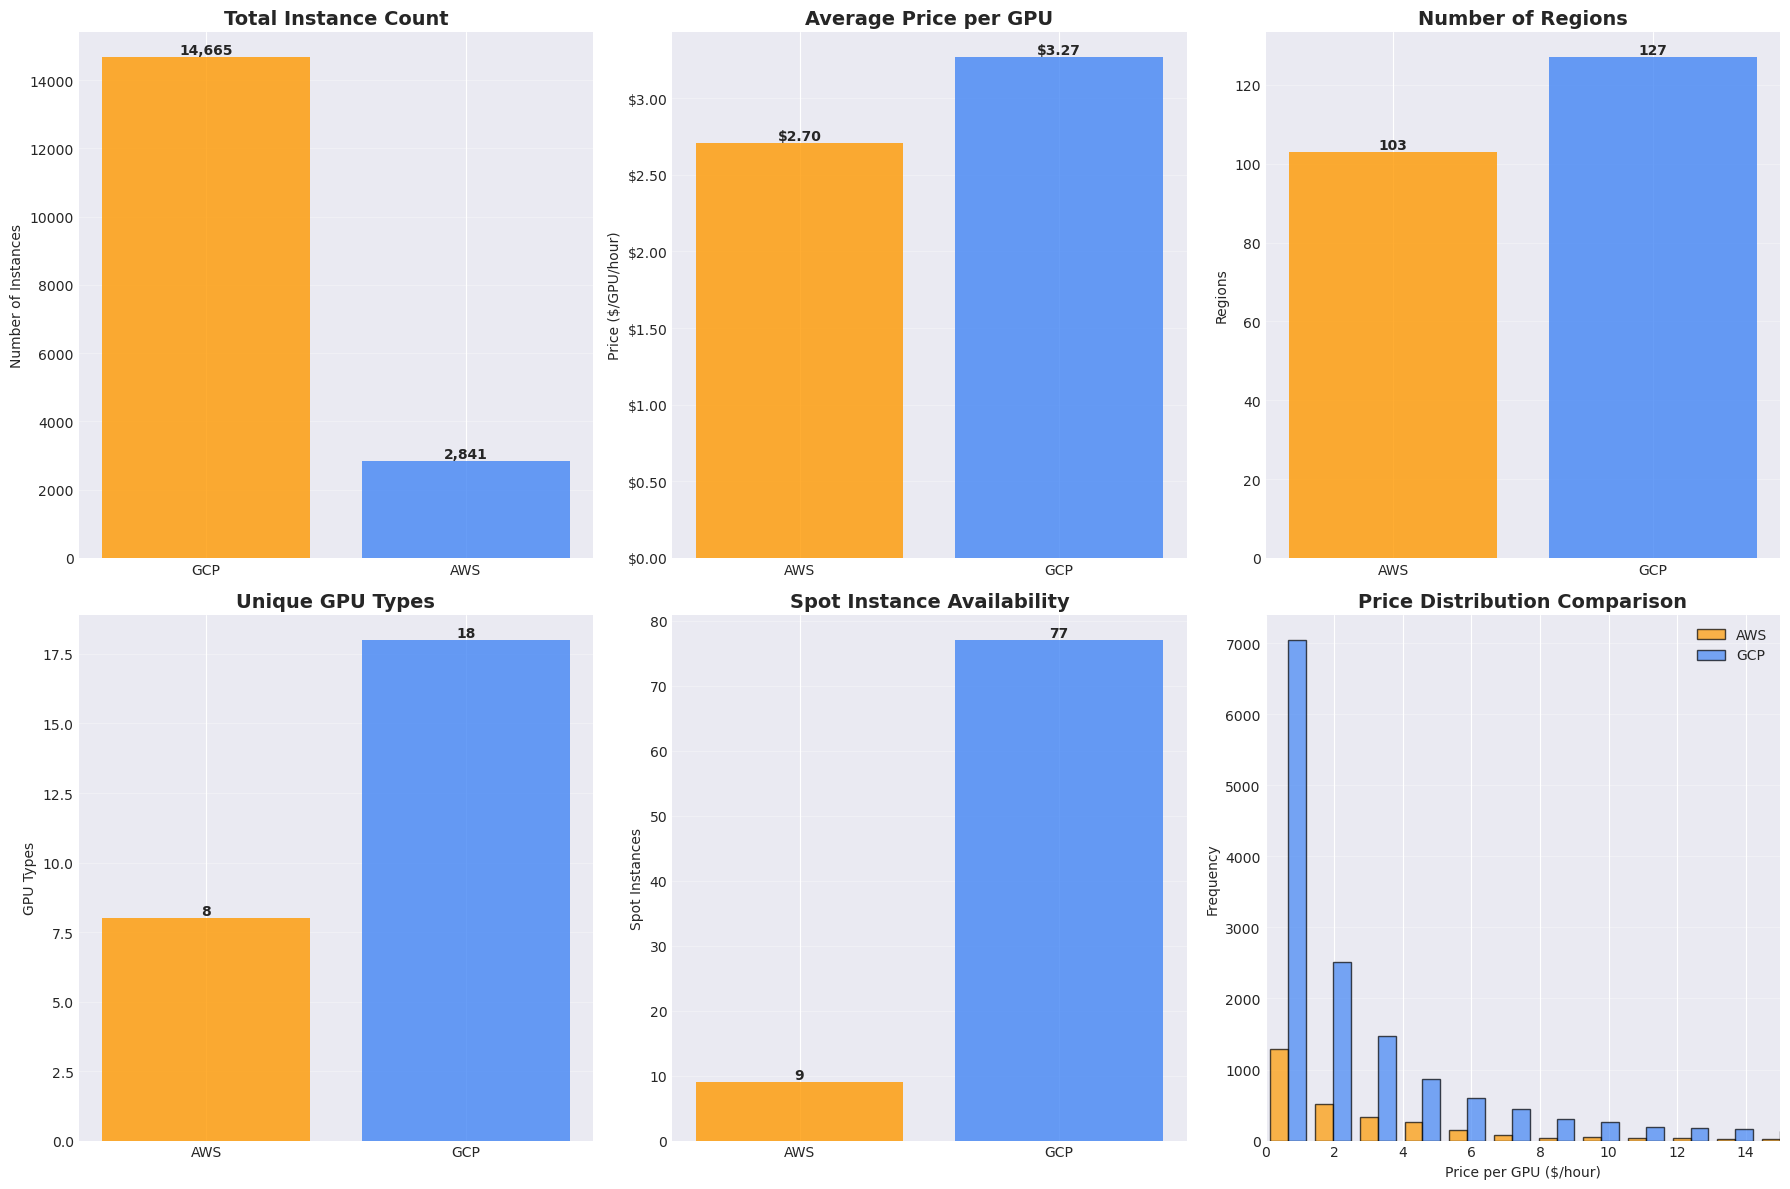

AWS vs GCP comparison saved to: reports/figures/aws_gcp_comparison.png


In [24]:
# Visual comparison: AWS vs GCP
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Instance count comparison
provider_counts = latest_df['provider'].value_counts()
axes[0, 0].bar(provider_counts.index, provider_counts.values, color=['#FF9900', '#4285F4'], alpha=0.8)
axes[0, 0].set_title('Total Instance Count', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Instances')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(provider_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# 2. Average price per GPU
avg_price = latest_df.groupby('provider')['price_per_gpu'].mean()
axes[0, 1].bar(avg_price.index, avg_price.values, color=['#FF9900', '#4285F4'], alpha=0.8)
axes[0, 1].set_title('Average Price per GPU', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Price ($/GPU/hour)')
axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(avg_price.values):
    axes[0, 1].text(i, v, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. Number of regions
region_count = latest_df.groupby('provider')['region'].nunique()
axes[0, 2].bar(region_count.index, region_count.values, color=['#FF9900', '#4285F4'], alpha=0.8)
axes[0, 2].set_title('Number of Regions', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Regions')
axes[0, 2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(region_count.values):
    axes[0, 2].text(i, v, f'{v}', ha='center', va='bottom', fontweight='bold')

# 4. GPU types available
gpu_types = latest_df.groupby('provider')['gpu_type'].nunique()
axes[1, 0].bar(gpu_types.index, gpu_types.values, color=['#FF9900', '#4285F4'], alpha=0.8)
axes[1, 0].set_title('Unique GPU Types', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('GPU Types')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(gpu_types.values):
    axes[1, 0].text(i, v, f'{v}', ha='center', va='bottom', fontweight='bold')

# 5. Spot instance availability
spot_counts = latest_df.groupby('provider')['is_spot'].sum()
axes[1, 1].bar(spot_counts.index, spot_counts.values, color=['#FF9900', '#4285F4'], alpha=0.8)
axes[1, 1].set_title('Spot Instance Availability', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Spot Instances')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(spot_counts.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# 6. Price distribution comparison
aws_prices = latest_df[latest_df['provider'] == 'AWS']['price_per_gpu']
gcp_prices = latest_df[latest_df['provider'] == 'GCP']['price_per_gpu']
axes[1, 2].hist([aws_prices, gcp_prices], bins=30, label=['AWS', 'GCP'], 
                color=['#FF9900', '#4285F4'], alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Price Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Price per GPU ($/hour)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()
axes[1, 2].set_xlim(0, 15)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reports/figures/aws_gcp_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("AWS vs GCP comparison saved to: reports/figures/aws_gcp_comparison.png")


## Regional Analysis


In [25]:
# Regional price analysis
regional_stats = latest_df.groupby(['provider', 'region']).agg({
    'price_per_gpu': ['mean', 'min', 'max', 'count'],
    'instance_type': 'nunique',
    'gpu_type': 'nunique'
}).round(2)

regional_stats.columns = ['Avg Price/GPU', 'Min Price/GPU', 'Max Price/GPU', 'Instance Count', 
                          'Instance Types', 'GPU Types']
regional_stats = regional_stats.reset_index()

# Find cheapest and most expensive regions
print("TOP 10 CHEAPEST REGIONS (Average Price per GPU)")
print("=" * 80)
cheapest_regions = regional_stats.nsmallest(10, 'Avg Price/GPU')
print(cheapest_regions[['provider', 'region', 'Avg Price/GPU', 'Instance Count', 'GPU Types']].to_string(index=False))

print("\n\nTOP 10 MOST EXPENSIVE REGIONS (Average Price per GPU)")
print("=" * 80)
expensive_regions = regional_stats.nlargest(10, 'Avg Price/GPU')
print(expensive_regions[['provider', 'region', 'Avg Price/GPU', 'Instance Count', 'GPU Types']].to_string(index=False))


TOP 10 CHEAPEST REGIONS (Average Price per GPU)
provider                region  Avg Price/GPU  Instance Count  GPU Types
     AWS       us-east-1-mci-1         0.4200               3          2
     AWS       us-east-1-msp-1         0.4200               3          2
     AWS       us-west-2-las-1         0.4200               3          2
     AWS       us-west-2-pdx-1         0.4200               3          2
     AWS       us-west-2-sea-1         0.4200               3          2
     AWS    eu-west-2-wl1-lon1         0.4800               3          2
     AWS    eu-west-2-wl1-man1         0.4800               3          2
     AWS    eu-west-2-wl2-man1         0.4800               3          2
     AWS eu-central-1-wl1-ber1         0.5100               3          2
     AWS eu-central-1-wl1-dtm1         0.5100               3          2


TOP 10 MOST EXPENSIVE REGIONS (Average Price per GPU)
provider                 region  Avg Price/GPU  Instance Count  GPU Types
     GCP      asia-

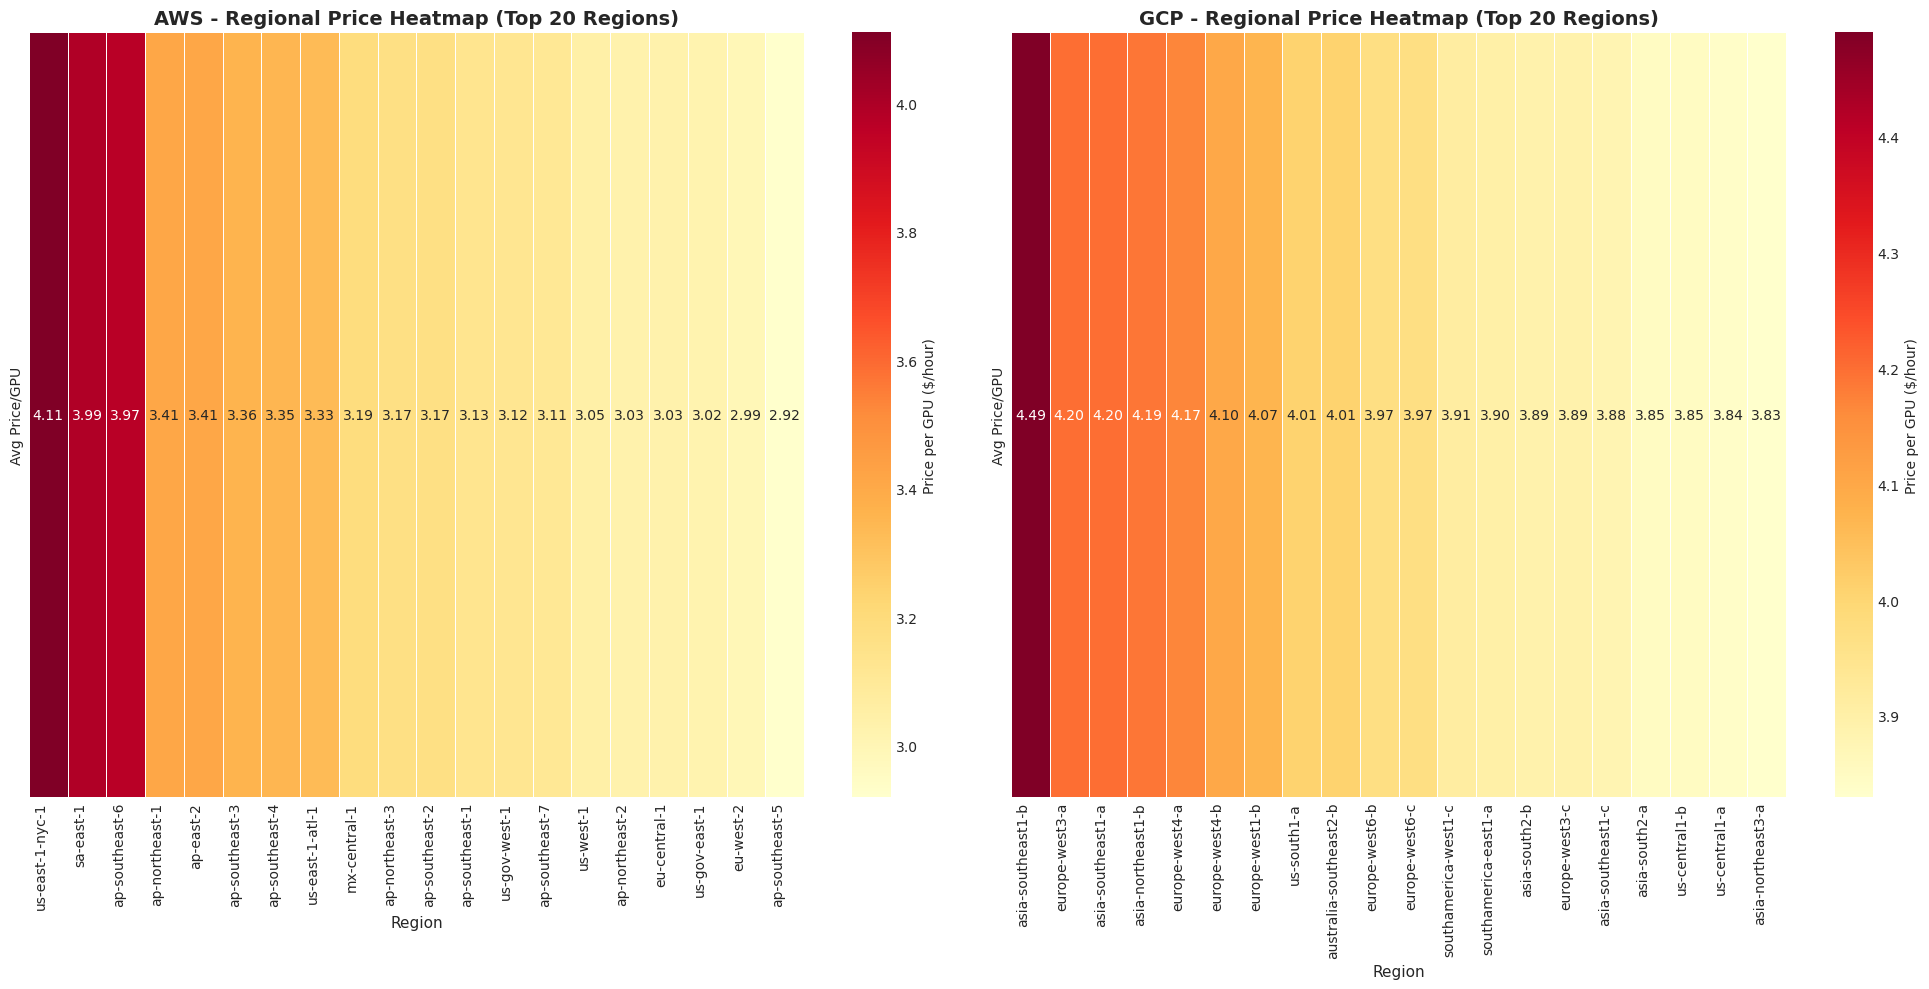

Regional price heatmaps saved to: reports/figures/aws_gcp_regional_heatmap.png


In [26]:
# Regional price heatmap by provider
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for idx, provider in enumerate(['AWS', 'GCP']):
    provider_regional = regional_stats[regional_stats['provider'] == provider].copy()
    
    if len(provider_regional) > 0:
        # Sort by average price
        provider_regional = provider_regional.sort_values('Avg Price/GPU', ascending=False)
        
        # Take top 20 regions for readability
        top_regions = provider_regional.head(20)
        
        # Create heatmap data
        heatmap_data = top_regions[['region', 'Avg Price/GPU']].set_index('region').T
        
        sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Price per GPU ($/hour)'},
                   ax=axes[idx], linewidths=0.5)
        axes[idx].set_title(f'{provider} - Regional Price Heatmap (Top 20 Regions)', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Region', fontsize=11)
        axes[idx].set_ylabel('')
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=90, ha='right')

plt.tight_layout()
plt.savefig('reports/figures/aws_gcp_regional_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Regional price heatmaps saved to: reports/figures/aws_gcp_regional_heatmap.png")


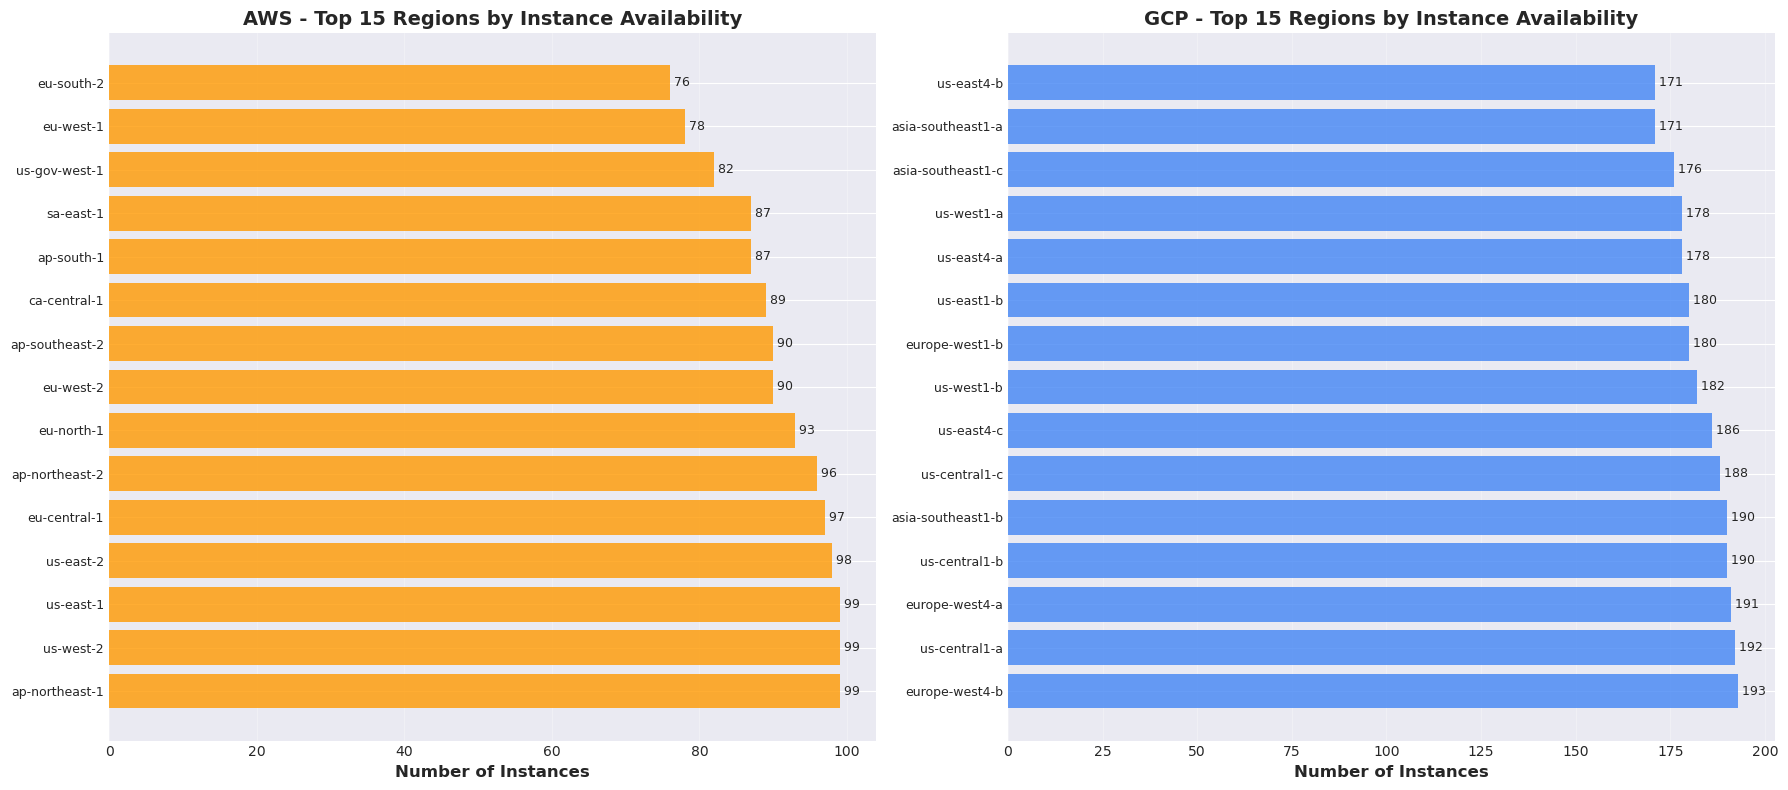

Regional availability comparison saved to: reports/figures/aws_gcp_regional_availability.png


In [27]:
# Regional availability comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, provider in enumerate(['AWS', 'GCP']):
    provider_regional = regional_stats[regional_stats['provider'] == provider].copy()
    provider_regional = provider_regional.sort_values('Instance Count', ascending=False).head(15)
    
    axes[idx].barh(range(len(provider_regional)), provider_regional['Instance Count'], 
                   color='#FF9900' if provider == 'AWS' else '#4285F4', alpha=0.8)
    axes[idx].set_yticks(range(len(provider_regional)))
    axes[idx].set_yticklabels(provider_regional['region'], fontsize=9)
    axes[idx].set_xlabel('Number of Instances', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{provider} - Top 15 Regions by Instance Availability', 
                       fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, v in enumerate(provider_regional['Instance Count']):
        axes[idx].text(v, i, f' {v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('reports/figures/aws_gcp_regional_availability.png', dpi=300, bbox_inches='tight')
plt.show()
print("Regional availability comparison saved to: reports/figures/aws_gcp_regional_availability.png")


## GPU Type Analysis


In [28]:
# GPU type comparison between AWS and GCP
gpu_comparison = latest_df.groupby(['provider', 'gpu_type']).agg({
    'price_per_gpu': ['mean', 'min', 'max', 'count'],
    'instance_type': 'nunique',
    'region': 'nunique'
}).round(2)

gpu_comparison.columns = ['Avg Price/GPU', 'Min Price/GPU', 'Max Price/GPU', 'Instance Count',
                          'Instance Types', 'Regions']
gpu_comparison = gpu_comparison.reset_index()

# Find common GPU types
aws_gpus = set(latest_df[latest_df['provider'] == 'AWS']['gpu_type'].unique())
gcp_gpus = set(latest_df[latest_df['provider'] == 'GCP']['gpu_type'].unique())
common_gpus = aws_gpus & gcp_gpus
aws_only = aws_gpus - gcp_gpus
gcp_only = gcp_gpus - aws_gpus

print("GPU TYPE AVAILABILITY")
print("=" * 80)
print(f"Common GPU types (available on both): {len(common_gpus)}")
print(f"AWS-only GPU types: {len(aws_only)}")
print(f"GCP-only GPU types: {len(gcp_only)}")

print(f"\n\nCommon GPU Types: {sorted(common_gpus)}")
print(f"\nAWS-Only GPU Types: {sorted(aws_only)}")
print(f"\nGCP-Only GPU Types: {sorted(gcp_only)}")


GPU TYPE AVAILABILITY
Common GPU types (available on both): 6
AWS-only GPU types: 2
GCP-only GPU types: 12


Common GPU Types: ['A100', 'H100', 'L4', 'T4', 'Unknown', 'V100']

AWS-Only GPU Types: ['A10G', 'L40S']

GCP-Only GPU Types: ['B200', 'P100', 'RTXPRO6000', 'v2-8', 'v3-8', 'v5litepod-1', 'v5litepod-4', 'v5litepod-8', 'v5p-8', 'v6e-1', 'v6e-4', 'v6e-8']




PRICE COMPARISON FOR COMMON GPU TYPES
          AWS Price  GCP Price  Difference ($)  Difference (%)
gpu_type                                                      
H100         8.3400     6.0600          2.2800         27.3000
V100         3.6500     2.7100          0.9400         25.8000
A100         3.5300     3.4700          0.0600          1.7000
Unknown      2.7600     3.4200         -0.6600        -23.9000
L4           2.0800     1.2100          0.8700         41.8000
T4           1.7300     0.9000          0.8300         48.0000


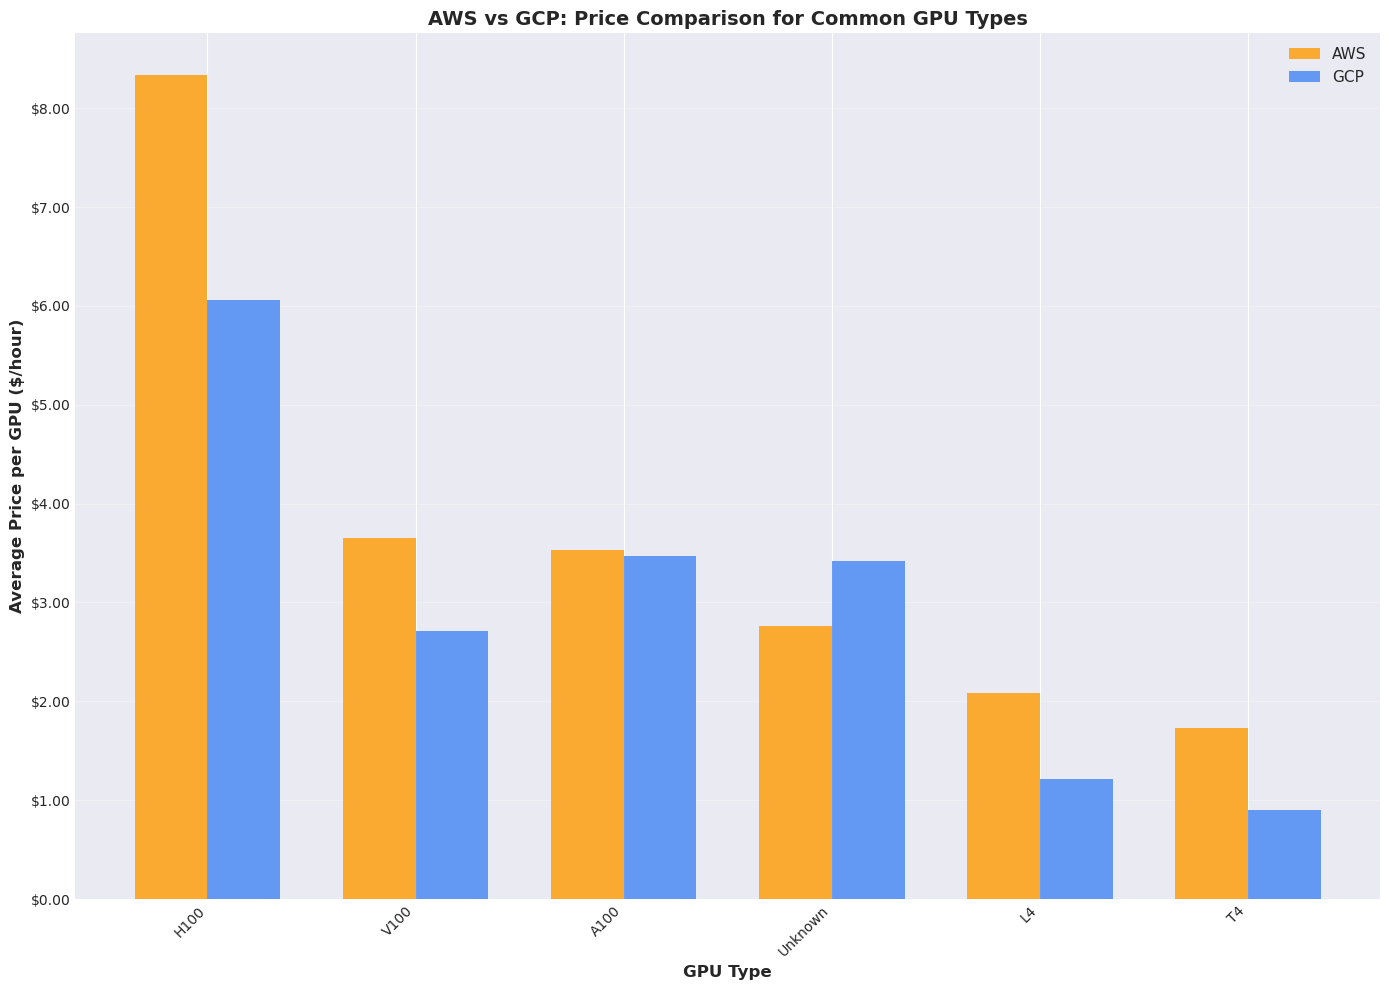


Price comparison chart saved to: reports/figures/aws_gcp_gpu_price_comparison.png


In [29]:
# Price comparison for common GPU types
if len(common_gpus) > 0:
    common_gpu_prices = gpu_comparison[gpu_comparison['gpu_type'].isin(common_gpus)].copy()
    
    # Pivot for easier comparison
    price_pivot = common_gpu_prices.pivot(index='gpu_type', columns='provider', values='Avg Price/GPU')
    price_pivot = price_pivot.sort_values('AWS', ascending=False)
    
    print("\n\nPRICE COMPARISON FOR COMMON GPU TYPES")
    print("=" * 80)
    price_pivot['Difference'] = (price_pivot['AWS'] - price_pivot['GCP']).round(2)
    price_pivot['Difference %'] = ((price_pivot['Difference'] / price_pivot['AWS']) * 100).round(1)
    price_pivot.columns = ['AWS Price', 'GCP Price', 'Difference ($)', 'Difference (%)']
    print(price_pivot.to_string())
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 10))
    x = np.arange(len(price_pivot))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, price_pivot['AWS Price'], width, 
                   label='AWS', color='#FF9900', alpha=0.8)
    bars2 = ax.bar(x + width/2, price_pivot['GCP Price'], width, 
                   label='GCP', color='#4285F4', alpha=0.8)
    
    ax.set_xlabel('GPU Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Price per GPU ($/hour)', fontsize=12, fontweight='bold')
    ax.set_title('AWS vs GCP: Price Comparison for Common GPU Types', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(price_pivot.index, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    
    plt.tight_layout()
    plt.savefig('reports/figures/aws_gcp_gpu_price_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nPrice comparison chart saved to: reports/figures/aws_gcp_gpu_price_comparison.png")
else:
    print("No common GPU types found between AWS and GCP.")


## Spot vs On-Demand Pricing Analysis


In [30]:
# Spot vs On-Demand comparison by provider
spot_analysis = latest_df.groupby(['provider', 'is_spot']).agg({
    'price_per_gpu': ['mean', 'min', 'max', 'count'],
    'instance_type': 'nunique',
    'gpu_type': 'nunique'
}).round(2)

spot_analysis.columns = ['Avg Price/GPU', 'Min Price/GPU', 'Max Price/GPU', 'Count',
                         'Instance Types', 'GPU Types']
spot_analysis = spot_analysis.reset_index()

# Pivot for comparison
spot_pivot = latest_df.pivot_table(
    index='provider',
    columns='is_spot',
    values='price_per_gpu',
    aggfunc='mean'
).round(2)
spot_pivot.columns = ['On-Demand', 'Spot']
spot_pivot['Savings $'] = (spot_pivot['On-Demand'] - spot_pivot['Spot']).round(2)
spot_pivot['Savings %'] = ((spot_pivot['Savings $'] / spot_pivot['On-Demand']) * 100).round(1)

print("SPOT vs ON-DEMAND PRICING COMPARISON")
print("=" * 80)
print(spot_pivot.to_string())

# Count comparison
spot_counts = latest_df.groupby(['provider', 'is_spot']).size().unstack(fill_value=0)
spot_counts.columns = ['On-Demand', 'Spot']
print(f"\n\nINSTANCE AVAILABILITY")
print("=" * 80)
print(spot_counts.to_string())


SPOT vs ON-DEMAND PRICING COMPARISON
          On-Demand   Spot  Savings $  Savings %
provider                                        
AWS          2.7000 5.1000    -2.4000   -88.9000
GCP          3.2700 2.6100     0.6600    20.2000


INSTANCE AVAILABILITY
          On-Demand  Spot
provider                 
AWS            2832     9
GCP           14588    77


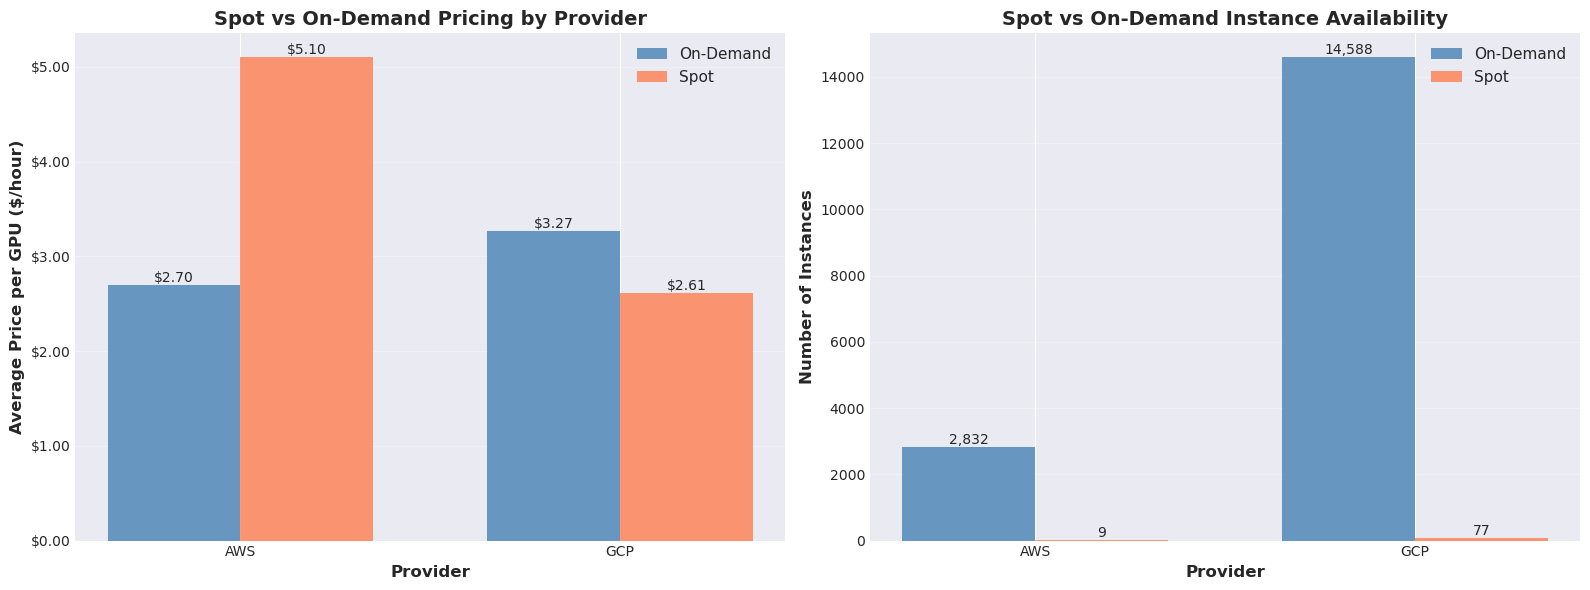

Spot vs on-demand analysis saved to: reports/figures/aws_gcp_spot_analysis.png


In [31]:
# Visualize spot vs on-demand
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Price comparison
x = np.arange(len(spot_pivot))
width = 0.35

bars1 = axes[0].bar(x - width/2, spot_pivot['On-Demand'], width, 
                    label='On-Demand', color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x + width/2, spot_pivot['Spot'], width, 
                    label='Spot', color='coral', alpha=0.8)

axes[0].set_xlabel('Provider', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Price per GPU ($/hour)', fontsize=12, fontweight='bold')
axes[0].set_title('Spot vs On-Demand Pricing by Provider', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(spot_pivot.index)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'${height:.2f}', ha='center', va='bottom', fontsize=10)

# Instance count comparison
x2 = np.arange(len(spot_counts))
bars3 = axes[1].bar(x2 - width/2, spot_counts['On-Demand'], width, 
                    label='On-Demand', color='steelblue', alpha=0.8)
bars4 = axes[1].bar(x2 + width/2, spot_counts['Spot'], width, 
                    label='Spot', color='coral', alpha=0.8)

axes[1].set_xlabel('Provider', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
axes[1].set_title('Spot vs On-Demand Instance Availability', fontsize=14, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(spot_counts.index)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axes[1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('reports/figures/aws_gcp_spot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Spot vs on-demand analysis saved to: reports/figures/aws_gcp_spot_analysis.png")


## Instance Type Deep Dive


In [32]:
# Analyze instance types by provider
instance_analysis = latest_df.groupby(['provider', 'instance_type']).agg({
    'price_per_hour': 'mean',
    'price_per_gpu': 'mean',
    'gpu_type': 'first',
    'gpu_count': 'first',
    'vcpus': 'first',
    'ram_gb': 'first',
    'region': 'nunique',
    'is_spot': lambda x: (x == True).sum()
}).round(2)

instance_analysis.columns = ['Price/hr', 'Price/GPU', 'GPU Type', 'GPU Count', 
                             'vCPUs', 'RAM (GB)', 'Regions', 'Spot Available']
instance_analysis = instance_analysis.reset_index()

# Find best value instances (lowest price per GPU with good specs)
print("TOP 20 BEST VALUE INSTANCES (Lowest Price per GPU)")
print("=" * 100)
best_value = instance_analysis.nsmallest(20, 'Price/GPU')
print(best_value[['provider', 'instance_type', 'GPU Type', 'GPU Count', 'vCPUs', 
                  'RAM (GB)', 'Price/GPU', 'Regions']].to_string(index=False))

# Find most expensive instances
print("\n\nTOP 20 MOST EXPENSIVE INSTANCES (Highest Price per GPU)")
print("=" * 100)
most_expensive = instance_analysis.nlargest(20, 'Price/GPU')
print(most_expensive[['provider', 'instance_type', 'GPU Type', 'GPU Count', 'vCPUs', 
                      'RAM (GB)', 'Price/GPU', 'Regions']].to_string(index=False))


TOP 20 BEST VALUE INSTANCES (Lowest Price per GPU)
provider instance_type GPU Type  GPU Count  vCPUs  RAM (GB)  Price/GPU  Regions
     AWS      t3.micro  Unknown          0      2    1.0000     0.0100       37
     AWS       t3.nano  Unknown          0      2    0.5000     0.0100       37
     AWS      t3.small  Unknown          0      2    2.0000     0.0200       37
     AWS      t2.small  Unknown          0      1    2.0000     0.0300       17
     AWS     t3.medium  Unknown          0      2    4.0000     0.0600      102
     GCP  e2-highcpu-2  Unknown          0      2    2.0000     0.0600      127
     GCP     e2-medium  Unknown          0      2    4.0000     0.0700      127
     GCP e2-standard-2  Unknown          0      2    8.0000     0.0800      127
     GCP  n2-highcpu-2  Unknown          0      2    2.0000     0.0900      121
     GCP  n4-highcpu-2  Unknown          0      2    4.0000     0.0900      102
     AWS      c5.large  Unknown          0      2    4.0000     0.100

In [33]:
# Analyze instance families
# Extract instance family prefixes
latest_df['instance_family'] = latest_df['instance_type'].str.split('.').str[0].str.split('-').str[0]

family_analysis = latest_df.groupby(['provider', 'instance_family']).agg({
    'price_per_gpu': ['mean', 'min', 'max', 'count'],
    'gpu_type': lambda x: ', '.join(x.unique()[:3]),  # Show first 3 GPU types
    'instance_type': 'nunique'
}).round(2)

family_analysis.columns = ['Avg Price/GPU', 'Min Price/GPU', 'Max Price/GPU', 'Count', 
                           'GPU Types', 'Instance Types']
family_analysis = family_analysis.reset_index()

print("INSTANCE FAMILY ANALYSIS")
print("=" * 100)
print(family_analysis.sort_values('Count', ascending=False).to_string(index=False))


INSTANCE FAMILY ANALYSIS
provider instance_family  Avg Price/GPU  Min Price/GPU  Max Price/GPU  Count                             GPU Types  Instance Types
     GCP              c4         4.9800         0.0900        29.8000   4301                               Unknown              57
     GCP              n2         2.7900         0.0700        12.3300   3509                               Unknown              29
     GCP              n4         1.7900         0.0800         7.6200   2448                               Unknown              24
     GCP              e2         0.4100         0.0500         1.7200   1905                               Unknown              15
     GCP              n1         1.4000         0.3600         3.6100   1220                        T4, P100, V100              24
     AWS              t3         0.1200         0.0100         0.5400    388                               Unknown               7
     AWS              m5         2.1400         0.1000    

## Time Series Analysis


Number of snapshots: 32


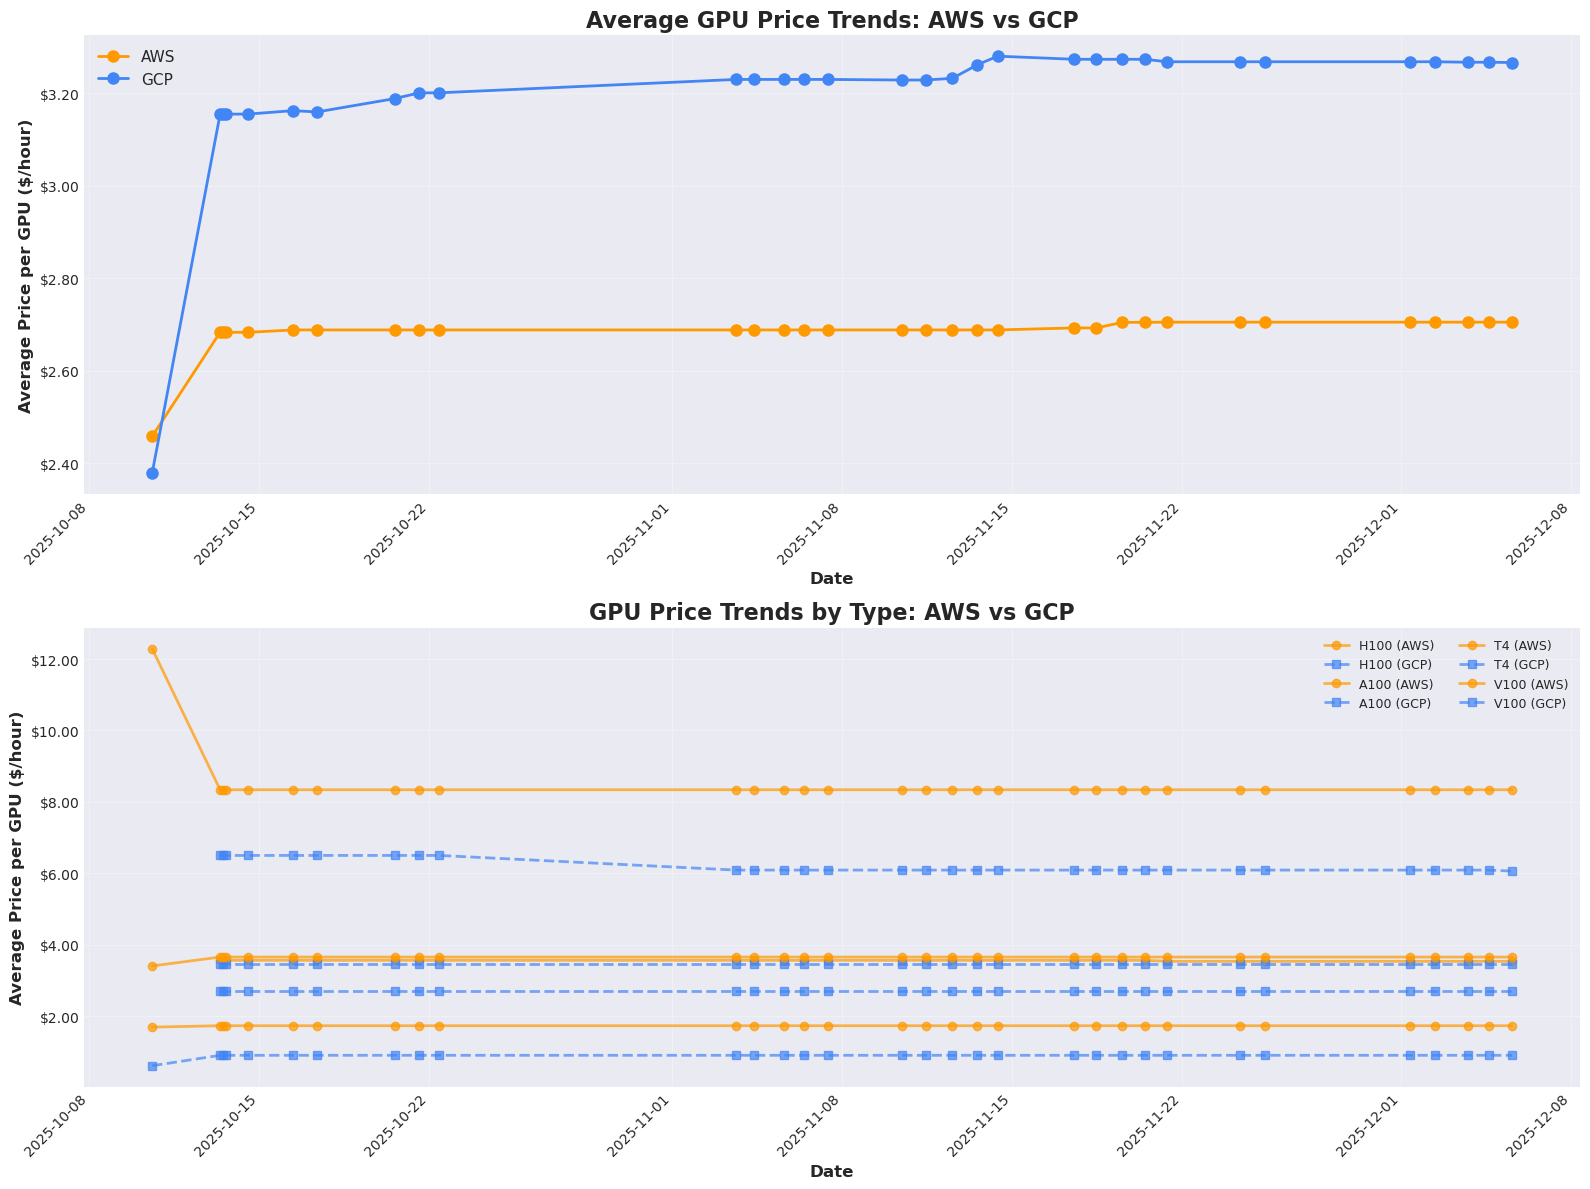

Price trends saved to: reports/figures/aws_gcp_price_trends.png


In [34]:
# Check if we have multiple snapshots
num_snapshots = df['timestamp'].nunique()
print(f"Number of snapshots: {num_snapshots}")

if num_snapshots > 1:
    # Average price trends by provider
    price_trends = df.groupby(['timestamp', 'provider'])['price_per_gpu'].mean().reset_index()
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot 1: Overall price trends
    for provider in ['AWS', 'GCP']:
        provider_data = price_trends[price_trends['provider'] == provider]
        if len(provider_data) > 0:
            axes[0].plot(provider_data['timestamp'], provider_data['price_per_gpu'], 
                        marker='o', linewidth=2, markersize=8, label=provider,
                        color='#FF9900' if provider == 'AWS' else '#4285F4')
    
    axes[0].set_title('Average GPU Price Trends: AWS vs GCP', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Average Price per GPU ($/hour)', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: Price trends for specific GPU types
    top_gpus = ['H100', 'A100', 'T4', 'V100']
    available_gpus = [gpu for gpu in top_gpus if gpu in df['gpu_type'].values]
    
    for gpu in available_gpus[:4]:
        gpu_trends = df[df['gpu_type'] == gpu].groupby(['timestamp', 'provider'])['price_per_gpu'].mean().reset_index()
        
        for provider in ['AWS', 'GCP']:
            provider_data = gpu_trends[gpu_trends['provider'] == provider]
            if len(provider_data) > 0:
                axes[1].plot(provider_data['timestamp'], provider_data['price_per_gpu'], 
                            marker='o' if provider == 'AWS' else 's', linewidth=2, 
                            markersize=6, label=f'{gpu} ({provider})',
                            linestyle='-' if provider == 'AWS' else '--',
                            color='#FF9900' if provider == 'AWS' else '#4285F4', alpha=0.7)
    
    axes[1].set_title('GPU Price Trends by Type: AWS vs GCP', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Average Price per GPU ($/hour)', fontsize=12, fontweight='bold')
    axes[1].legend(loc='best', fontsize=9, ncol=2)
    axes[1].grid(True, alpha=0.3)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('reports/figures/aws_gcp_price_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Price trends saved to: reports/figures/aws_gcp_price_trends.png")
else:
    print("Need multiple snapshots for time series analysis.")


## Instance Count Analysis Over Time


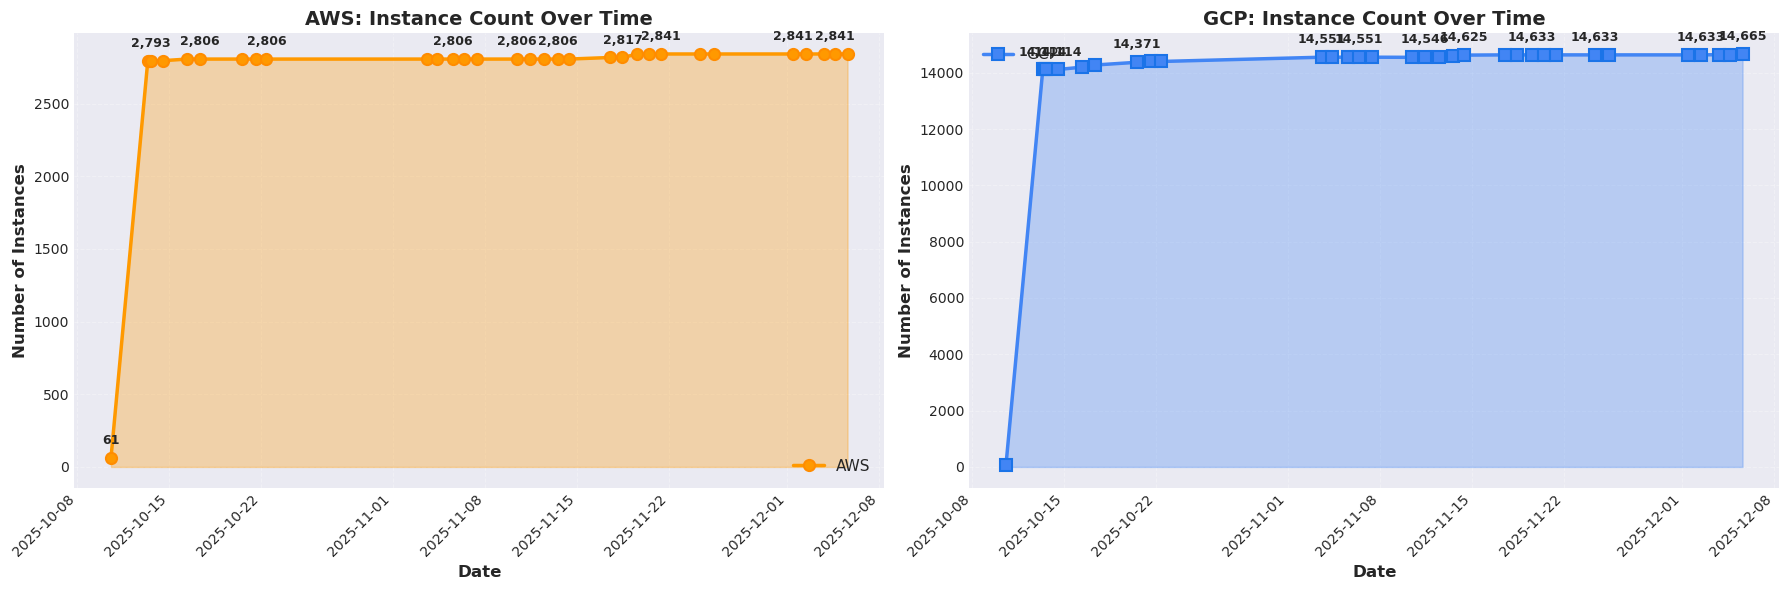

Instance count plots (separate) saved to: reports/figures/aws_gcp_instance_counts_separate.png

INSTANCE COUNT SUMMARY
AWS:
  Initial count: 61 instances
  Final count: 2,841 instances
  Change: +2,780 instances
  Average: 2730 instances
  Max: 2,841 instances
  Min: 61 instances

GCP:
  Initial count: 71 instances
  Final count: 14,665 instances
  Change: +14,594 instances
  Average: 14045 instances
  Max: 14,665 instances
  Min: 71 instances


In [35]:
# Detailed instance count analysis over time for AWS and GCP separately
if num_snapshots > 1:
    # Calculate instance counts by provider over time
    instance_counts_by_provider = df.groupby(['timestamp', 'provider']).size().reset_index(name='instance_count')
    
    # Separate AWS and GCP data
    aws_counts = instance_counts_by_provider[instance_counts_by_provider['provider'] == 'AWS']
    gcp_counts = instance_counts_by_provider[instance_counts_by_provider['provider'] == 'GCP']
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # AWS instance count over time
    if len(aws_counts) > 0:
        axes[0].plot(aws_counts['timestamp'], aws_counts['instance_count'], 
                    marker='o', linewidth=2.5, markersize=8, color='#FF9900', 
                    label='AWS', markerfacecolor='#FF9900', markeredgecolor='darkorange', 
                    markeredgewidth=1.5)
        axes[0].fill_between(aws_counts['timestamp'], aws_counts['instance_count'], 
                            alpha=0.3, color='#FF9900')
        axes[0].set_title('AWS: Instance Count Over Time', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Date', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3, linestyle='--')
        axes[0].legend(fontsize=11)
        
        # Add value annotations
        for i, row in aws_counts.iterrows():
            if i % max(1, len(aws_counts) // 10) == 0:  # Annotate every nth point
                axes[0].annotate(f'{int(row["instance_count"]):,}', 
                               (row['timestamp'], row['instance_count']),
                               textcoords="offset points", xytext=(0,10), ha='center',
                               fontsize=9, fontweight='bold')
    
    # GCP instance count over time
    if len(gcp_counts) > 0:
        axes[1].plot(gcp_counts['timestamp'], gcp_counts['instance_count'], 
                    marker='s', linewidth=2.5, markersize=8, color='#4285F4', 
                    label='GCP', markerfacecolor='#4285F4', markeredgecolor='#1a73e8', 
                    markeredgewidth=1.5)
        axes[1].fill_between(gcp_counts['timestamp'], gcp_counts['instance_count'], 
                            alpha=0.3, color='#4285F4')
        axes[1].set_title('GCP: Instance Count Over Time', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3, linestyle='--')
        axes[1].legend(fontsize=11)
        
        # Add value annotations
        for i, row in gcp_counts.iterrows():
            if i % max(1, len(gcp_counts) // 10) == 0:  # Annotate every nth point
                axes[1].annotate(f'{int(row["instance_count"]):,}', 
                               (row['timestamp'], row['instance_count']),
                               textcoords="offset points", xytext=(0,10), ha='center',
                               fontsize=9, fontweight='bold')
    
    # Rotate x-axis labels
    for ax in axes:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('reports/figures/aws_gcp_instance_counts_separate.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Instance count plots (separate) saved to: reports/figures/aws_gcp_instance_counts_separate.png")
    
    # Print summary statistics
    print("\nINSTANCE COUNT SUMMARY")
    print("=" * 80)
    if len(aws_counts) > 0:
        print(f"AWS:")
        print(f"  Initial count: {aws_counts.iloc[0]['instance_count']:,} instances")
        print(f"  Final count: {aws_counts.iloc[-1]['instance_count']:,} instances")
        print(f"  Change: {aws_counts.iloc[-1]['instance_count'] - aws_counts.iloc[0]['instance_count']:+,} instances")
        print(f"  Average: {aws_counts['instance_count'].mean():.0f} instances")
        print(f"  Max: {aws_counts['instance_count'].max():,} instances")
        print(f"  Min: {aws_counts['instance_count'].min():,} instances")
    
    if len(gcp_counts) > 0:
        print(f"\nGCP:")
        print(f"  Initial count: {gcp_counts.iloc[0]['instance_count']:,} instances")
        print(f"  Final count: {gcp_counts.iloc[-1]['instance_count']:,} instances")
        print(f"  Change: {gcp_counts.iloc[-1]['instance_count'] - gcp_counts.iloc[0]['instance_count']:+,} instances")
        print(f"  Average: {gcp_counts['instance_count'].mean():.0f} instances")
        print(f"  Max: {gcp_counts['instance_count'].max():,} instances")
        print(f"  Min: {gcp_counts['instance_count'].min():,} instances")
else:
    print("Need multiple snapshots for instance count time series analysis.")


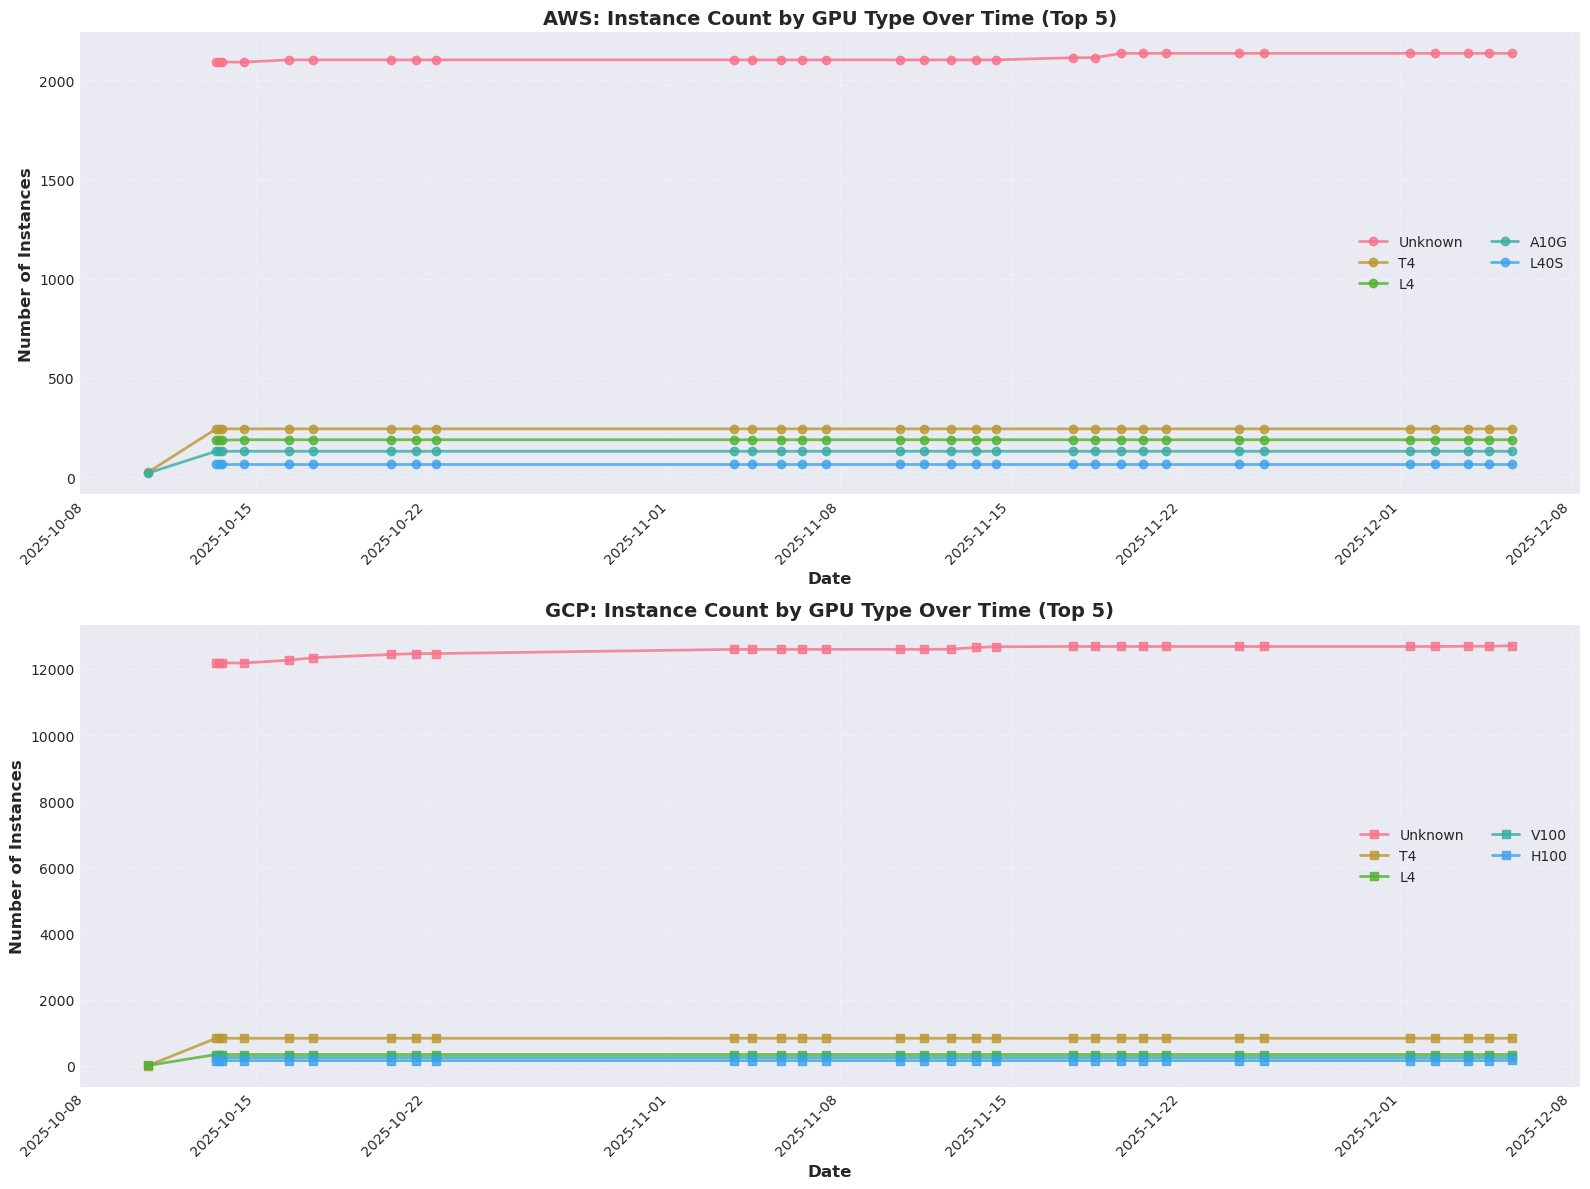

Instance count by GPU type saved to: reports/figures/aws_gcp_instance_counts_by_gpu_type.png


In [36]:
# Instance count by GPU type over time for each provider
if num_snapshots > 1:
    # Get top GPU types for each provider
    top_aws_gpus = df[df['provider'] == 'AWS']['gpu_type'].value_counts().head(5).index.tolist()
    top_gcp_gpus = df[df['provider'] == 'GCP']['gpu_type'].value_counts().head(5).index.tolist()
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # AWS GPU type instance counts over time
    if len(top_aws_gpus) > 0:
        for gpu in top_aws_gpus:
            gpu_data = df[(df['provider'] == 'AWS') & (df['gpu_type'] == gpu)]
            gpu_counts = gpu_data.groupby('timestamp').size().reset_index(name='count')
            if len(gpu_counts) > 0:
                axes[0].plot(gpu_counts['timestamp'], gpu_counts['count'], 
                            marker='o', linewidth=2, markersize=6, label=gpu, alpha=0.8)
        
        axes[0].set_title('AWS: Instance Count by GPU Type Over Time (Top 5)', 
                         fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Date', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
        axes[0].legend(loc='best', fontsize=10, ncol=2)
        axes[0].grid(True, alpha=0.3, linestyle='--')
        plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # GCP GPU type instance counts over time
    if len(top_gcp_gpus) > 0:
        for gpu in top_gcp_gpus:
            gpu_data = df[(df['provider'] == 'GCP') & (df['gpu_type'] == gpu)]
            gpu_counts = gpu_data.groupby('timestamp').size().reset_index(name='count')
            if len(gpu_counts) > 0:
                axes[1].plot(gpu_counts['timestamp'], gpu_counts['count'], 
                            marker='s', linewidth=2, markersize=6, label=gpu, alpha=0.8)
        
        axes[1].set_title('GCP: Instance Count by GPU Type Over Time (Top 5)', 
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
        axes[1].legend(loc='best', fontsize=10, ncol=2)
        axes[1].grid(True, alpha=0.3, linestyle='--')
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('reports/figures/aws_gcp_instance_counts_by_gpu_type.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Instance count by GPU type saved to: reports/figures/aws_gcp_instance_counts_by_gpu_type.png")


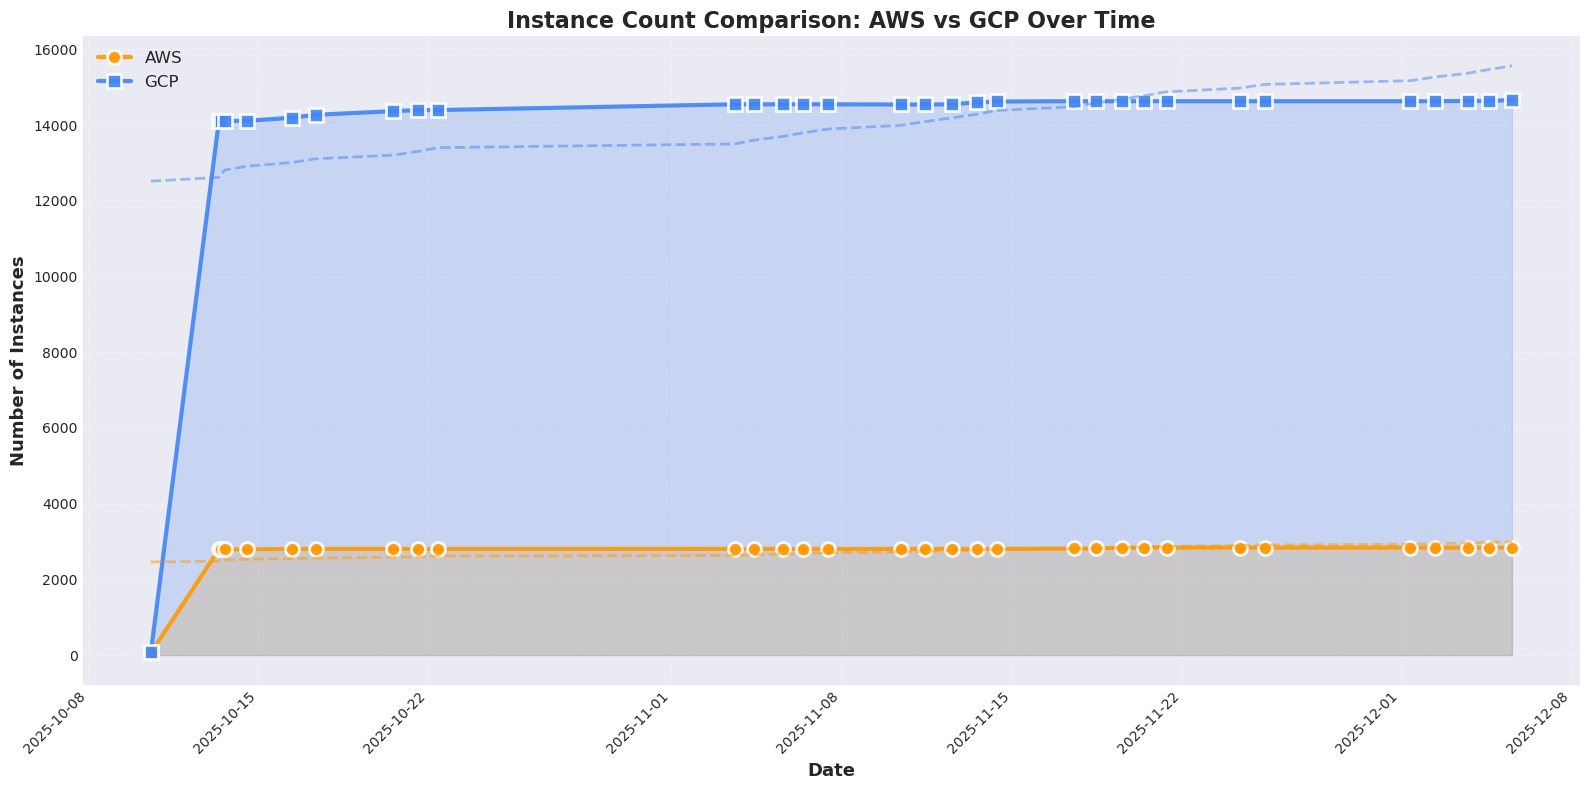

Instance count comparison saved to: reports/figures/aws_gcp_instance_counts_comparison.png


In [37]:
# Instance count comparison: AWS vs GCP on same plot
if num_snapshots > 1:
    instance_counts_by_provider = df.groupby(['timestamp', 'provider']).size().reset_index(name='instance_count')
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot both providers on same axes
    for provider in ['AWS', 'GCP']:
        provider_data = instance_counts_by_provider[instance_counts_by_provider['provider'] == provider]
        if len(provider_data) > 0:
            color = '#FF9900' if provider == 'AWS' else '#4285F4'
            marker = 'o' if provider == 'AWS' else 's'
            ax.plot(provider_data['timestamp'], provider_data['instance_count'], 
                   marker=marker, linewidth=3, markersize=10, label=provider,
                   color=color, markerfacecolor=color, markeredgecolor='white', 
                   markeredgewidth=2, alpha=0.9)
            ax.fill_between(provider_data['timestamp'], provider_data['instance_count'], 
                           alpha=0.2, color=color)
    
    ax.set_title('Instance Count Comparison: AWS vs GCP Over Time', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Instances', fontsize=13, fontweight='bold')
    ax.legend(fontsize=12, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add trend lines
    if len(instance_counts_by_provider) > 1:
        for provider in ['AWS', 'GCP']:
            provider_data = instance_counts_by_provider[instance_counts_by_provider['provider'] == provider]
            if len(provider_data) > 1:
                z = np.polyfit(range(len(provider_data)), provider_data['instance_count'], 1)
                p = np.poly1d(z)
                color = '#FF9900' if provider == 'AWS' else '#4285F4'
                ax.plot(provider_data['timestamp'], p(range(len(provider_data))), 
                       "--", linewidth=2, alpha=0.5, color=color, 
                       label=f'{provider} Trend')
    
    plt.tight_layout()
    plt.savefig('reports/figures/aws_gcp_instance_counts_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Instance count comparison saved to: reports/figures/aws_gcp_instance_counts_comparison.png")


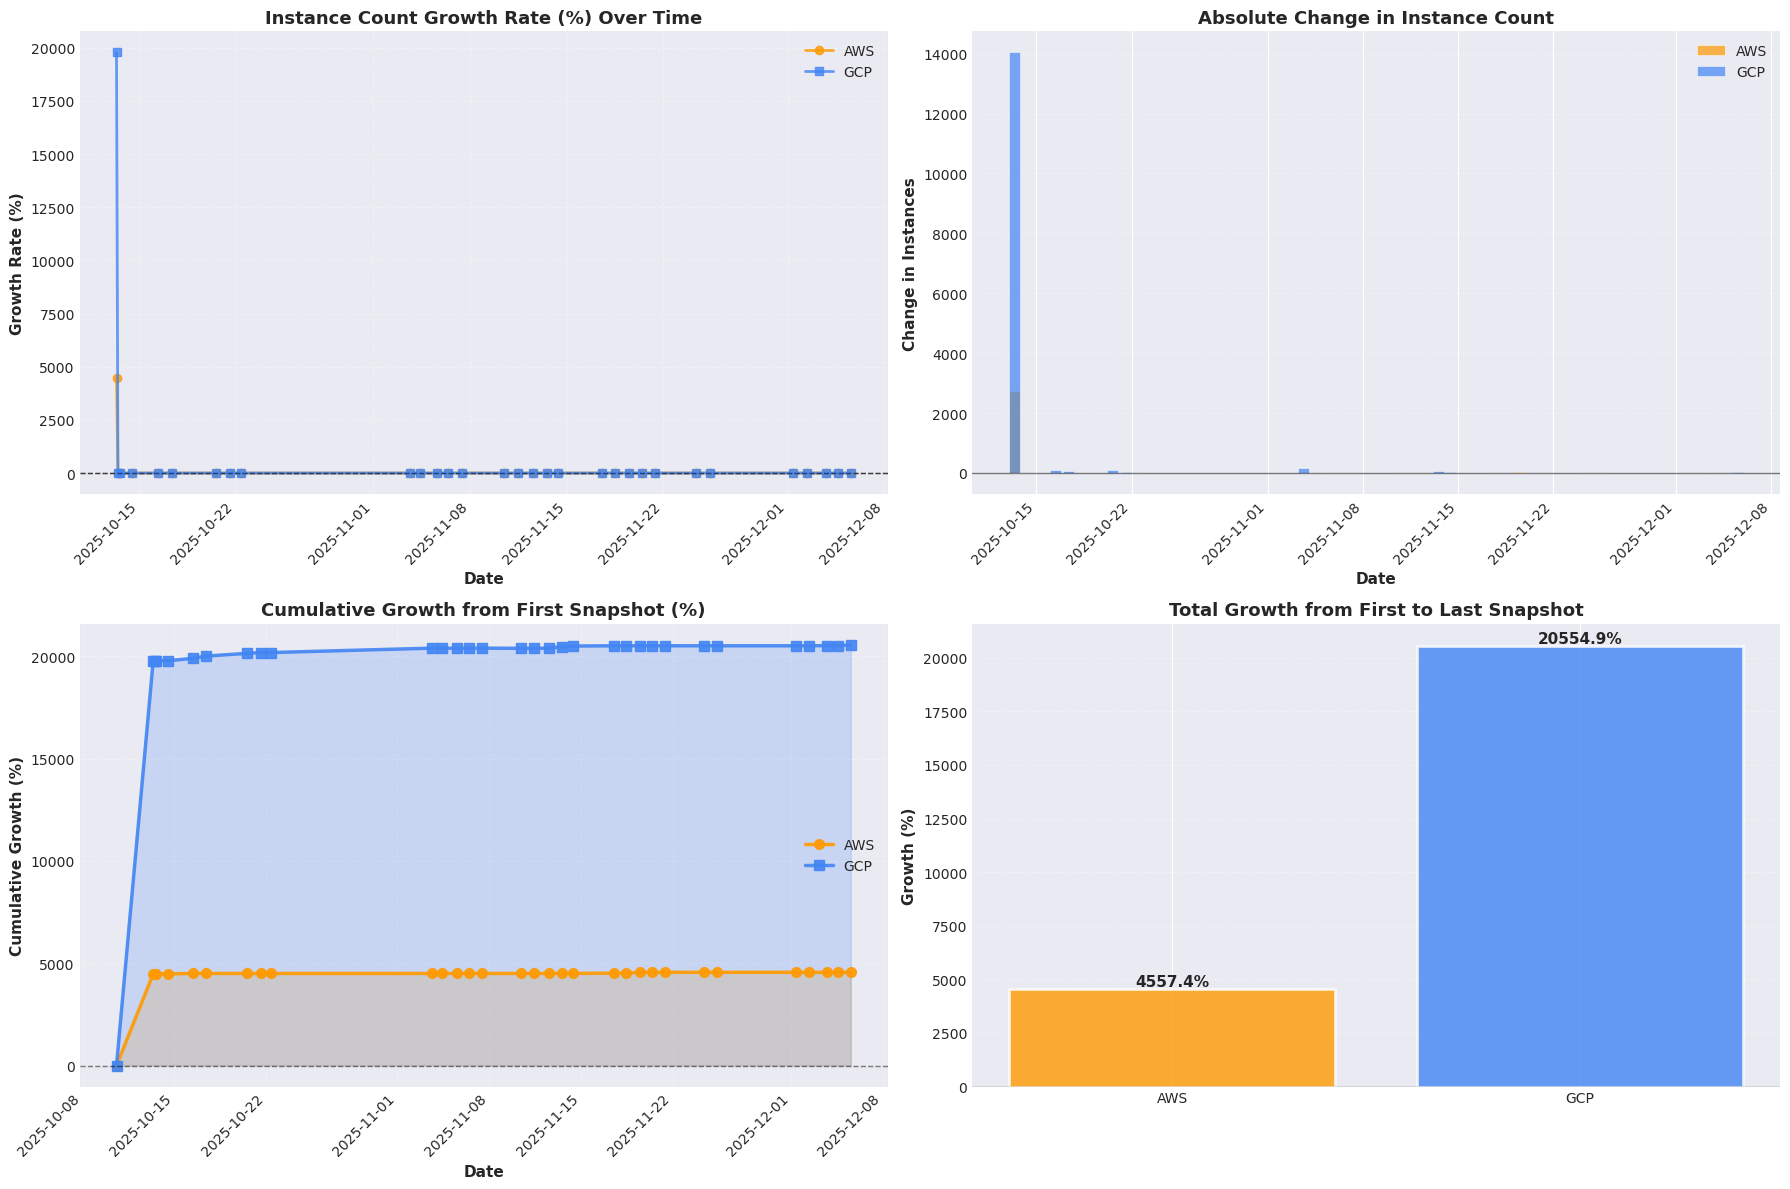

Instance growth analysis saved to: reports/figures/aws_gcp_instance_growth_analysis.png


In [38]:
# Instance count growth rate analysis
if num_snapshots > 1:
    instance_counts_by_provider = df.groupby(['timestamp', 'provider']).size().reset_index(name='instance_count')
    
    # Calculate growth rates
    growth_data = []
    for provider in ['AWS', 'GCP']:
        provider_data = instance_counts_by_provider[instance_counts_by_provider['provider'] == provider].copy()
        if len(provider_data) > 1:
            provider_data = provider_data.sort_values('timestamp')
            provider_data['growth'] = provider_data['instance_count'].pct_change() * 100
            provider_data['absolute_change'] = provider_data['instance_count'].diff()
            growth_data.append(provider_data)
    
    if len(growth_data) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
        # Plot 1: Growth rate percentage
        for provider_data in growth_data:
            provider = provider_data['provider'].iloc[0]
            color = '#FF9900' if provider == 'AWS' else '#4285F4'
            axes[0, 0].plot(provider_data['timestamp'], provider_data['growth'], 
                           marker='o' if provider == 'AWS' else 's', linewidth=2, 
                           markersize=6, label=provider, color=color, alpha=0.8)
            axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        axes[0, 0].set_title('Instance Count Growth Rate (%) Over Time', 
                            fontsize=13, fontweight='bold')
        axes[0, 0].set_xlabel('Date', fontsize=11, fontweight='bold')
        axes[0, 0].set_ylabel('Growth Rate (%)', fontsize=11, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3, linestyle='--')
        plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Plot 2: Absolute change
        for provider_data in growth_data:
            provider = provider_data['provider'].iloc[0]
            color = '#FF9900' if provider == 'AWS' else '#4285F4'
            axes[0, 1].bar(provider_data['timestamp'], provider_data['absolute_change'], 
                          width=0.8, label=provider, color=color, alpha=0.7, 
                          edgecolor='white', linewidth=0.5)
        
        axes[0, 1].set_title('Absolute Change in Instance Count', 
                            fontsize=13, fontweight='bold')
        axes[0, 1].set_xlabel('Date', fontsize=11, fontweight='bold')
        axes[0, 1].set_ylabel('Change in Instances', fontsize=11, fontweight='bold')
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3, linestyle='--', axis='y')
        axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Plot 3: Cumulative growth
        for provider_data in growth_data:
            provider = provider_data['provider'].iloc[0]
            provider_data = provider_data.sort_values('timestamp')
            initial_count = provider_data.iloc[0]['instance_count']
            provider_data['cumulative_growth'] = ((provider_data['instance_count'] - initial_count) / initial_count) * 100
            color = '#FF9900' if provider == 'AWS' else '#4285F4'
            axes[1, 0].plot(provider_data['timestamp'], provider_data['cumulative_growth'], 
                           marker='o' if provider == 'AWS' else 's', linewidth=2.5, 
                           markersize=7, label=provider, color=color, alpha=0.9)
            axes[1, 0].fill_between(provider_data['timestamp'], provider_data['cumulative_growth'], 
                                   alpha=0.2, color=color)
        
        axes[1, 0].set_title('Cumulative Growth from First Snapshot (%)', 
                            fontsize=13, fontweight='bold')
        axes[1, 0].set_xlabel('Date', fontsize=11, fontweight='bold')
        axes[1, 0].set_ylabel('Cumulative Growth (%)', fontsize=11, fontweight='bold')
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, linestyle='--')
        axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Plot 4: Side-by-side bar chart of total growth
        total_growth = []
        for provider_data in growth_data:
            provider = provider_data['provider'].iloc[0]
            initial = provider_data.iloc[0]['instance_count']
            final = provider_data.iloc[-1]['instance_count']
            growth_pct = ((final - initial) / initial) * 100 if initial > 0 else 0
            total_growth.append({'Provider': provider, 'Growth %': growth_pct, 
                               'Initial': initial, 'Final': final})
        
        growth_df = pd.DataFrame(total_growth)
        colors = ['#FF9900' if p == 'AWS' else '#4285F4' for p in growth_df['Provider']]
        bars = axes[1, 1].bar(growth_df['Provider'], growth_df['Growth %'], 
                             color=colors, alpha=0.8, edgecolor='white', linewidth=2)
        axes[1, 1].set_title('Total Growth from First to Last Snapshot', 
                            fontsize=13, fontweight='bold')
        axes[1, 1].set_ylabel('Growth (%)', fontsize=11, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, linestyle='--', axis='y')
        axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        # Add value labels
        for bar, row in zip(bars, growth_df.itertuples()):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
                           fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('reports/figures/aws_gcp_instance_growth_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Instance growth analysis saved to: reports/figures/aws_gcp_instance_growth_analysis.png")


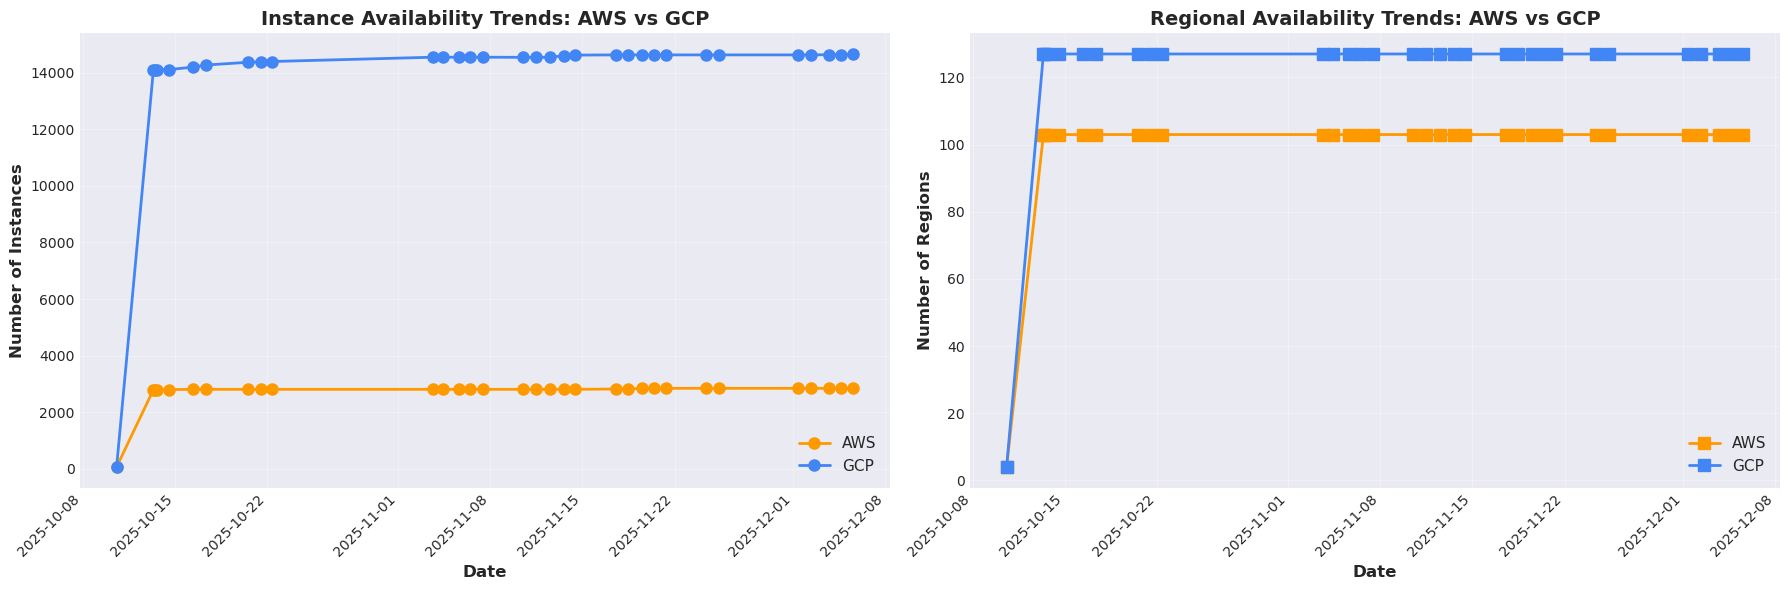

Availability trends saved to: reports/figures/aws_gcp_availability_trends.png


In [39]:
# Instance availability trends over time
if num_snapshots > 1:
    availability_trends = df.groupby(['timestamp', 'provider']).size().reset_index(name='instance_count')
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: Total instance count over time
    for provider in ['AWS', 'GCP']:
        provider_data = availability_trends[availability_trends['provider'] == provider]
        if len(provider_data) > 0:
            axes[0].plot(provider_data['timestamp'], provider_data['instance_count'], 
                        marker='o', linewidth=2, markersize=8, label=provider,
                        color='#FF9900' if provider == 'AWS' else '#4285F4')
    
    axes[0].set_title('Instance Availability Trends: AWS vs GCP', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: Regional availability trends
    regional_trends = df.groupby(['timestamp', 'provider'])['region'].nunique().reset_index(name='region_count')
    
    for provider in ['AWS', 'GCP']:
        provider_data = regional_trends[regional_trends['provider'] == provider]
        if len(provider_data) > 0:
            axes[1].plot(provider_data['timestamp'], provider_data['region_count'], 
                        marker='s', linewidth=2, markersize=8, label=provider,
                        color='#FF9900' if provider == 'AWS' else '#4285F4')
    
    axes[1].set_title('Regional Availability Trends: AWS vs GCP', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Number of Regions', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('reports/figures/aws_gcp_availability_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Availability trends saved to: reports/figures/aws_gcp_availability_trends.png")


## Cost Optimization Insights


In [40]:
# Calculate cost per vCPU and cost per GB RAM for better comparison
latest_df['cost_per_vcpu'] = latest_df['price_per_hour'] / latest_df['vcpus'].replace(0, 1)
latest_df['cost_per_gb_ram'] = latest_df['price_per_hour'] / latest_df['ram_gb'].replace(0, 1)

# Best value analysis
value_metrics = latest_df.groupby(['provider', 'gpu_type']).agg({
    'price_per_gpu': 'min',
    'cost_per_vcpu': 'min',
    'cost_per_gb_ram': 'min',
    'instance_type': 'first',
    'gpu_count': 'first',
    'vcpus': 'first',
    'ram_gb': 'first',
    'region': 'first'
}).round(4)

value_metrics.columns = ['Best Price/GPU', 'Best Cost/vCPU', 'Best Cost/GB RAM',
                         'Instance Type', 'GPU Count', 'vCPUs', 'RAM (GB)', 'Region']
value_metrics = value_metrics.reset_index()

print("COST OPTIMIZATION: Best Value Instances by GPU Type")
print("=" * 120)
print(value_metrics.sort_values('Best Price/GPU').head(20).to_string(index=False))


COST OPTIMIZATION: Best Value Instances by GPU Type
provider    gpu_type  Best Price/GPU  Best Cost/vCPU  Best Cost/GB RAM   Instance Type  GPU Count  vCPUs  RAM (GB)        Region
     AWS     Unknown          0.0052          0.0026            0.0083     c5.12xlarge          0     48   96.0000    ap-south-1
     GCP     Unknown          0.0495          0.0247            0.0053  c4-highcpu-144          0    144  288.0000    us-west1-c
     GCP          T4          0.3619          0.0500            0.0113   n1-340-48-tpu          4     48  340.0000    us-east1-d
     AWS          T4          0.5260          0.0680            0.0170   g4dn.12xlarge          4     48  192.0000     us-east-1
     GCP          L4          0.7064          0.0541            0.0135  g2-standard-12          1     12   48.0000    us-east4-c
     AWS          L4          0.8048          0.0531            0.0096     g6.12xlarge          4     48  192.0000     us-east-1
     AWS        A10G          1.0060         

In [41]:
# Spot instance savings analysis
spot_savings = latest_df[latest_df['is_spot'] == True].copy()

if len(spot_savings) > 0:
    # For each spot instance, find corresponding on-demand price
    spot_with_ondemand = []
    
    for _, spot_row in spot_savings.iterrows():
        # Find matching on-demand instance
        ondemand_match = latest_df[
            (latest_df['provider'] == spot_row['provider']) &
            (latest_df['instance_type'] == spot_row['instance_type']) &
            (latest_df['region'] == spot_row['region']) &
            (latest_df['is_spot'] == False)
        ]
        
        if len(ondemand_match) > 0:
            ondemand_price = ondemand_match.iloc[0]['price_per_gpu']
            savings = ondemand_price - spot_row['price_per_gpu']
            savings_pct = (savings / ondemand_price) * 100 if ondemand_price > 0 else 0
            
            spot_with_ondemand.append({
                'provider': spot_row['provider'],
                'instance_type': spot_row['instance_type'],
                'gpu_type': spot_row['gpu_type'],
                'region': spot_row['region'],
                'spot_price': spot_row['price_per_gpu'],
                'ondemand_price': ondemand_price,
                'savings': savings,
                'savings_pct': savings_pct
            })
    
    if len(spot_with_ondemand) > 0:
        savings_df = pd.DataFrame(spot_with_ondemand)
        
        print("TOP 20 SPOT INSTANCE SAVINGS OPPORTUNITIES")
        print("=" * 100)
        top_savings = savings_df.nlargest(20, 'savings_pct')
        print(top_savings[['provider', 'instance_type', 'gpu_type', 'region', 
                           'spot_price', 'ondemand_price', 'savings', 'savings_pct']].to_string(index=False))
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Savings by provider
        provider_savings = savings_df.groupby('provider')['savings_pct'].mean()
        axes[0].bar(provider_savings.index, provider_savings.values, 
                   color=['#FF9900', '#4285F4'], alpha=0.8)
        axes[0].set_title('Average Spot Savings by Provider', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Average Savings (%)', fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(provider_savings.values):
            axes[0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Top savings opportunities
        top_10 = savings_df.nlargest(10, 'savings_pct')
        axes[1].barh(range(len(top_10)), top_10['savings_pct'], 
                    color=['#FF9900' if p == 'AWS' else '#4285F4' for p in top_10['provider']], alpha=0.8)
        axes[1].set_yticks(range(len(top_10)))
        axes[1].set_yticklabels([f"{row['gpu_type']} ({row['provider']})" 
                                 for _, row in top_10.iterrows()], fontsize=9)
        axes[1].set_xlabel('Savings (%)', fontsize=12, fontweight='bold')
        axes[1].set_title('Top 10 Spot Savings Opportunities', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.savefig('reports/figures/aws_gcp_spot_savings.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\nSpot savings analysis saved to: reports/figures/aws_gcp_spot_savings.png")
    else:
        print("No matching on-demand instances found for spot instances.")
else:
    print("No spot instances available in the data.")


No matching on-demand instances found for spot instances.


## Regional Price Variations


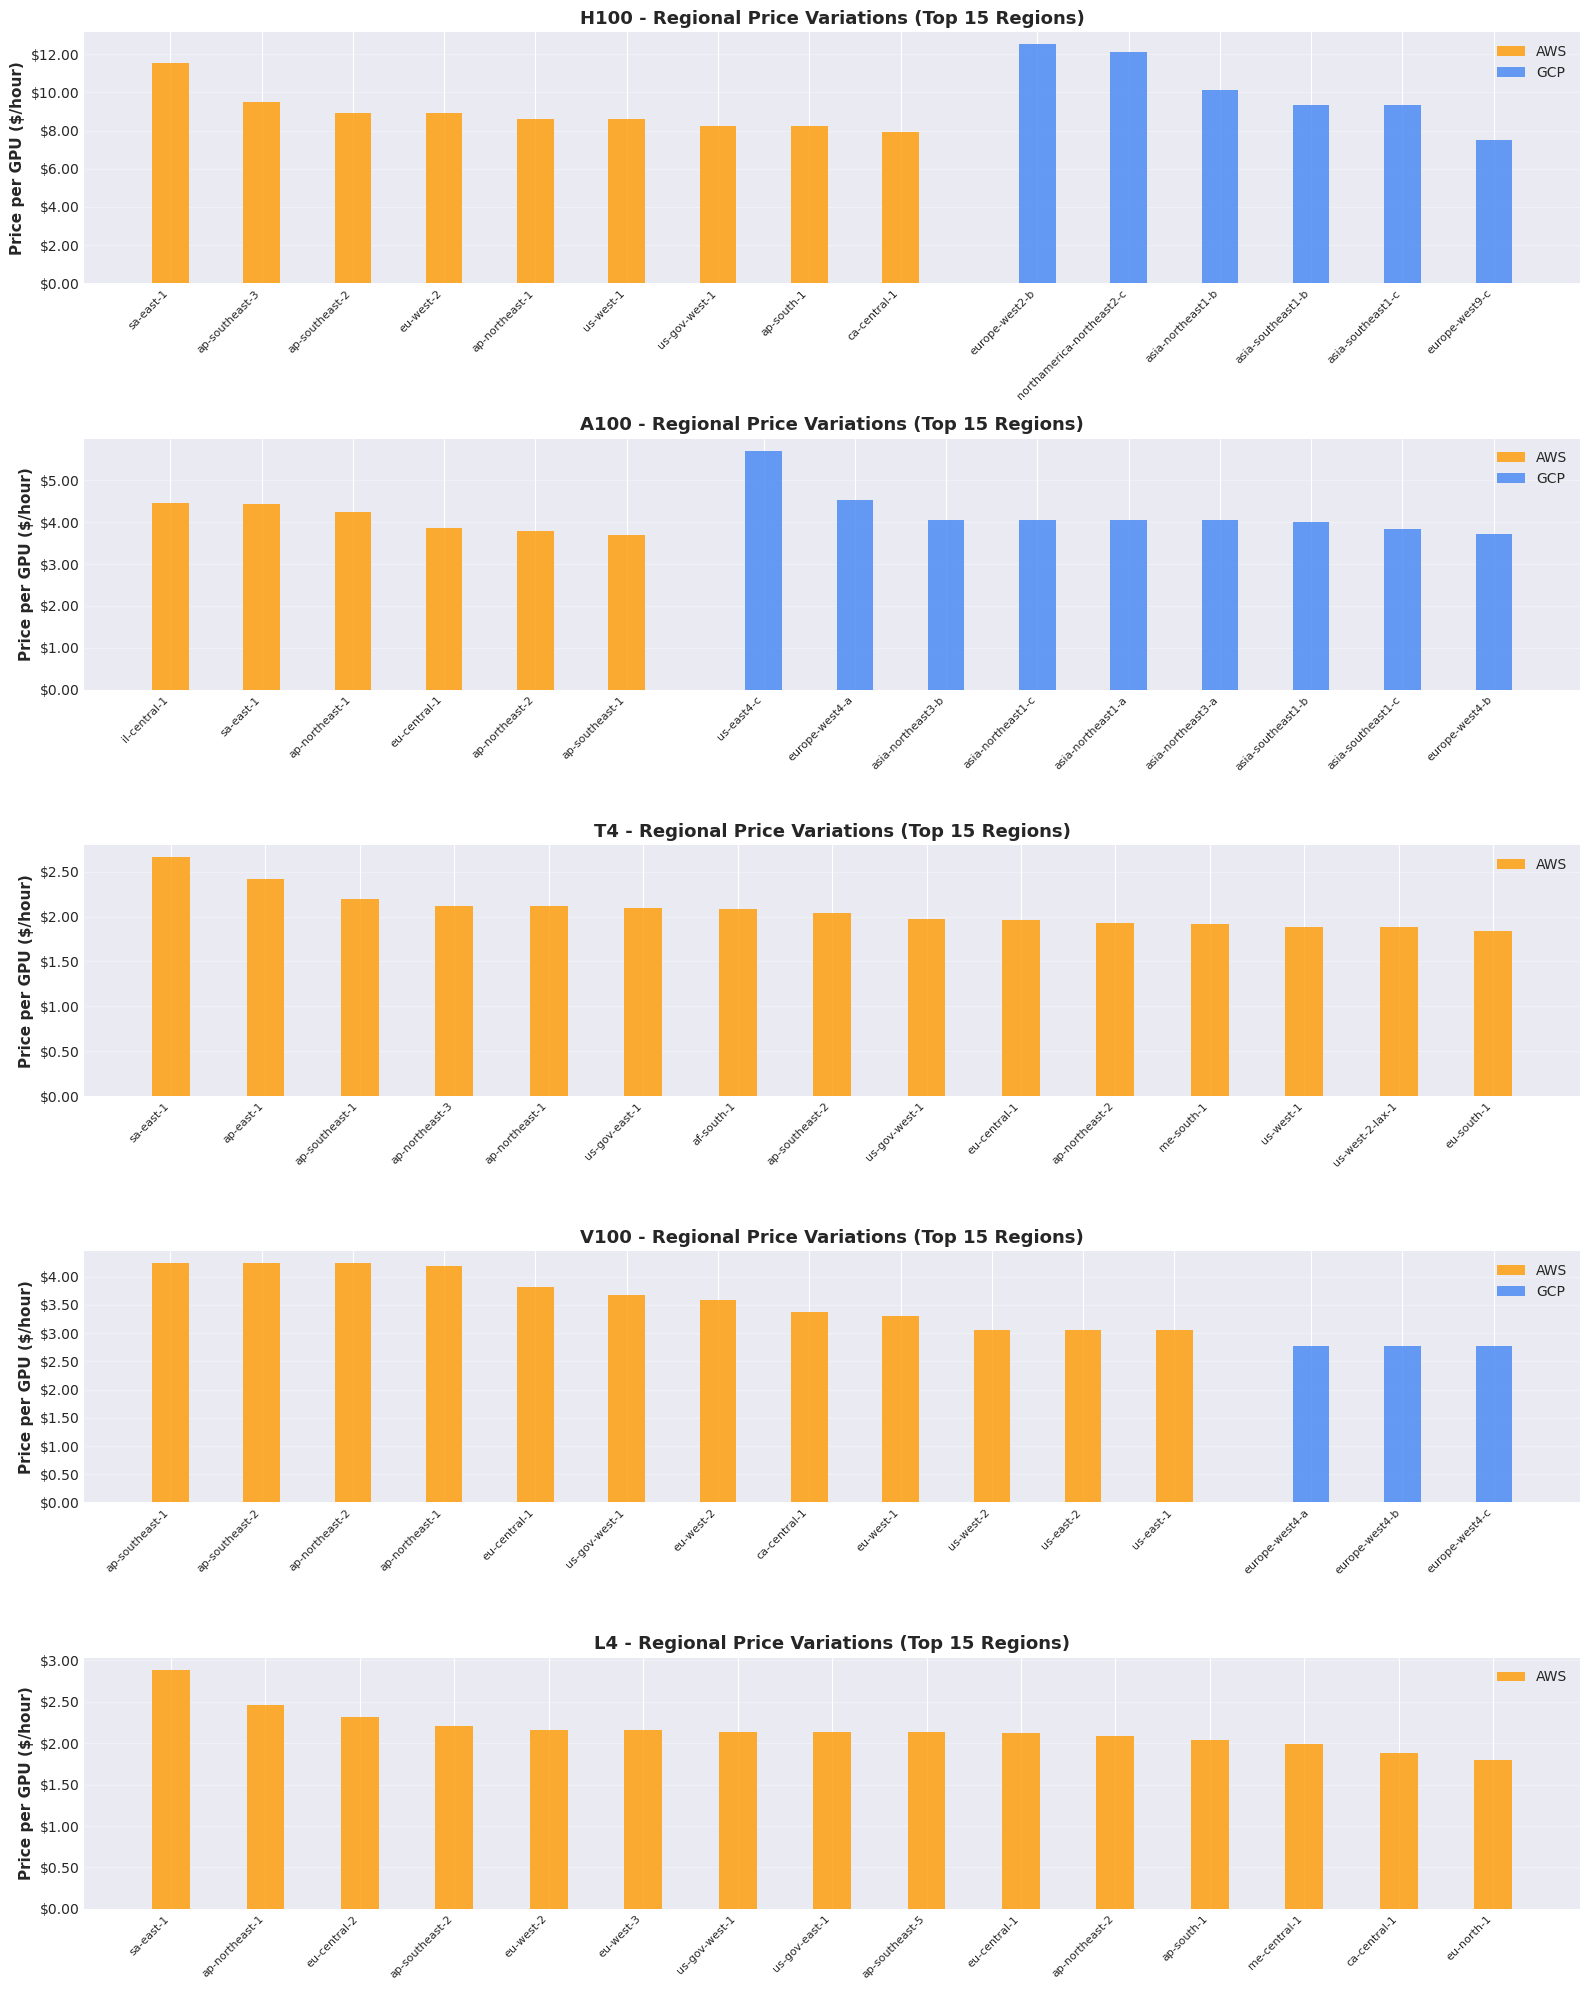

Regional price variations saved to: reports/figures/aws_gcp_regional_gpu_variations.png


In [42]:
# Analyze price variations across regions for specific GPU types
top_gpus_for_regional = ['H100', 'A100', 'T4', 'V100', 'L4']
available_gpus_regional = [gpu for gpu in top_gpus_for_regional if gpu in latest_df['gpu_type'].values]

if len(available_gpus_regional) > 0:
    fig, axes = plt.subplots(len(available_gpus_regional), 1, figsize=(16, 4*len(available_gpus_regional)))
    if len(available_gpus_regional) == 1:
        axes = [axes]
    
    for idx, gpu in enumerate(available_gpus_regional[:5]):
        gpu_regional = latest_df[latest_df['gpu_type'] == gpu].groupby(['provider', 'region'])['price_per_gpu'].mean().reset_index()
        gpu_regional = gpu_regional.sort_values('price_per_gpu', ascending=False).head(15)
        
        # Separate by provider
        aws_data = gpu_regional[gpu_regional['provider'] == 'AWS']
        gcp_data = gpu_regional[gpu_regional['provider'] == 'GCP']
        
        x_aws = range(len(aws_data))
        x_gcp = [i + len(aws_data) + 0.5 for i in range(len(gcp_data))]
        
        if len(aws_data) > 0:
            axes[idx].bar(x_aws, aws_data['price_per_gpu'], width=0.4, 
                         label='AWS', color='#FF9900', alpha=0.8)
        if len(gcp_data) > 0:
            axes[idx].bar(x_gcp, gcp_data['price_per_gpu'], width=0.4, 
                         label='GCP', color='#4285F4', alpha=0.8)
        
        all_labels = list(aws_data['region']) + list(gcp_data['region'])
        all_x = list(x_aws) + list(x_gcp)
        
        axes[idx].set_xticks(all_x)
        axes[idx].set_xticklabels(all_labels, rotation=45, ha='right', fontsize=8)
        axes[idx].set_ylabel('Price per GPU ($/hour)', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{gpu} - Regional Price Variations (Top 15 Regions)', 
                           fontsize=13, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(True, alpha=0.3, axis='y')
        axes[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    
    plt.tight_layout()
    plt.savefig('reports/figures/aws_gcp_regional_gpu_variations.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Regional price variations saved to: reports/figures/aws_gcp_regional_gpu_variations.png")


## Summary and Recommendations


In [43]:
# Generate summary statistics
print("=" * 100)
print("AWS vs GCP ANALYSIS SUMMARY")
print("=" * 100)

print(f"\n1. INSTANCE AVAILABILITY")
print(f"   AWS: {len(latest_df[latest_df['provider'] == 'AWS']):,} instances")
print(f"   GCP: {len(latest_df[latest_df['provider'] == 'GCP']):,} instances")

print(f"\n2. PRICING")
aws_avg = latest_df[latest_df['provider'] == 'AWS']['price_per_gpu'].mean()
gcp_avg = latest_df[latest_df['provider'] == 'GCP']['price_per_gpu'].mean()
print(f"   AWS Average Price/GPU: ${aws_avg:.2f}/hour")
print(f"   GCP Average Price/GPU: ${gcp_avg:.2f}/hour")
if aws_avg < gcp_avg:
    print(f"   → AWS is {((gcp_avg - aws_avg) / gcp_avg * 100):.1f}% cheaper on average")
else:
    print(f"   → GCP is {((aws_avg - gcp_avg) / aws_avg * 100):.1f}% cheaper on average")

print(f"\n3. REGIONAL COVERAGE")
aws_regions = latest_df[latest_df['provider'] == 'AWS']['region'].nunique()
gcp_regions = latest_df[latest_df['provider'] == 'GCP']['region'].nunique()
print(f"   AWS: {aws_regions} regions")
print(f"   GCP: {gcp_regions} regions")

print(f"\n4. GPU TYPE DIVERSITY")
aws_gpus = latest_df[latest_df['provider'] == 'AWS']['gpu_type'].nunique()
gcp_gpus = latest_df[latest_df['provider'] == 'GCP']['gpu_type'].nunique()
print(f"   AWS: {aws_gpus} unique GPU types")
print(f"   GCP: {gcp_gpus} unique GPU types")

print(f"\n5. SPOT INSTANCE AVAILABILITY")
aws_spot = latest_df[(latest_df['provider'] == 'AWS') & (latest_df['is_spot'] == True)].shape[0]
gcp_spot = latest_df[(latest_df['provider'] == 'GCP') & (latest_df['is_spot'] == True)].shape[0]
print(f"   AWS: {aws_spot:,} spot instances")
print(f"   GCP: {gcp_spot:,} spot instances")

print(f"\n6. CHEAPEST REGIONS")
cheapest_aws = regional_stats[regional_stats['provider'] == 'AWS'].nsmallest(1, 'Avg Price/GPU')
cheapest_gcp = regional_stats[regional_stats['provider'] == 'GCP'].nsmallest(1, 'Avg Price/GPU')
if len(cheapest_aws) > 0:
    print(f"   AWS: {cheapest_aws.iloc[0]['region']} (${cheapest_aws.iloc[0]['Avg Price/GPU']:.2f}/GPU)")
if len(cheapest_gcp) > 0:
    print(f"   GCP: {cheapest_gcp.iloc[0]['region']} (${cheapest_gcp.iloc[0]['Avg Price/GPU']:.2f}/GPU)")

print("\n" + "=" * 100)


AWS vs GCP ANALYSIS SUMMARY

1. INSTANCE AVAILABILITY
   AWS: 2,841 instances
   GCP: 14,665 instances

2. PRICING
   AWS Average Price/GPU: $2.70/hour
   GCP Average Price/GPU: $3.27/hour
   → AWS is 17.2% cheaper on average

3. REGIONAL COVERAGE
   AWS: 103 regions
   GCP: 127 regions

4. GPU TYPE DIVERSITY
   AWS: 8 unique GPU types
   GCP: 18 unique GPU types

5. SPOT INSTANCE AVAILABILITY
   AWS: 9 spot instances
   GCP: 77 spot instances

6. CHEAPEST REGIONS
   AWS: us-east-1-mci-1 ($0.42/GPU)
   GCP: europe-north2-c ($1.71/GPU)



In [44]:
# Close connection
conn.close()
print("\nAnalysis complete! All visualizations saved to reports/figures/")



Analysis complete! All visualizations saved to reports/figures/
